In [6]:
import random
import numpy as np

np.random.seed(42)  # Replace 42 with your desired seed value
random.seed(42)  # Replace 42 with your desired seed value

In [7]:
"""
Also bei den MaMel handelt es sich um verschiedene Melanom Kulturen
einer Patientin. Das interessante ist, eine Kultur schlägt an bei der
Behandlung mit Interferon Gamma und die andere nicht. Diese zwei
Kulturen und weitere befinden sich in den gemessenen Daten. Dabei
interessieren mich aber nur die Unterschiede der zwei Kulturen in
Detail. Die Kulturen, um die es geht, sind 86c auf L-Lysine (reagiert)
und 68a alt (reagiert nicht). Dabei wurden hier verschiedene Zeitpunkte 
gemessen, bei denen die Reaktion immer weiter fortschreitet. Es ist
also nicht nur interessant, den Unterschied der beiden zu sehen im
Vergleich zur Behandlung, sondern auch über die Zeit.
"""

'\nAlso bei den MaMel handelt es sich um verschiedene Melanom Kulturen\neiner Patientin. Das interessante ist, eine Kultur schlägt an bei der\nBehandlung mit Interferon Gamma und die andere nicht. Diese zwei\nKulturen und weitere befinden sich in den gemessenen Daten. Dabei\ninteressieren mich aber nur die Unterschiede der zwei Kulturen in\nDetail. Die Kulturen, um die es geht, sind 86c auf L-Lysine (reagiert)\nund 68a alt (reagiert nicht). Dabei wurden hier verschiedene Zeitpunkte \ngemessen, bei denen die Reaktion immer weiter fortschreitet. Es ist\nalso nicht nur interessant, den Unterschied der beiden zu sehen im\nVergleich zur Behandlung, sondern auch über die Zeit.\n'

In [8]:
"""
TODO
- What to do treatment vs. timepoints vs. concentrations 
"""

'\nTODO\n- What to do treatment vs. timepoints vs. concentrations \n'

In [9]:
import os
import pandas as pd

In [10]:
os.chdir("/home/ubuntu/CellPainting/MaMel")

In [11]:
df_treatments = pd.read_excel("machine_readable_plate_layout_mamel_2024.xlsx", index_col=0, sheet_name="Treatments")
df_concentrations = pd.read_excel("machine_readable_plate_layout_mamel_2024.xlsx", index_col=0, sheet_name="Concentrations")

In [12]:
df_treatments = df_treatments.reset_index().melt(id_vars='index', var_name='col_index', value_name='Metadata_Cellline')
df_treatments.rename(columns={'index': 'row_index'}, inplace=True)

df_concentrations = df_concentrations.reset_index().melt(id_vars='index', var_name='col_index', value_name='Metadata_Concentrations')
df_concentrations.rename(columns={'index': 'row_index'}, inplace=True)

df_treatments['col_index'] = df_treatments['col_index'].astype(str).str.zfill(2)
df_concentrations['col_index'] = df_concentrations['col_index'].astype(str).str.zfill(2)

df_treatments['Metadata_Well'] = df_treatments['row_index'] + df_treatments['col_index']
df_concentrations['Metadata_Well'] = df_concentrations['row_index'] + df_concentrations['col_index']

conc_dict = df_concentrations.set_index('Metadata_Well')['Metadata_Concentrations'].to_dict()
treat_dict = df_treatments.set_index('Metadata_Well')['Metadata_Cellline'].to_dict()

In [13]:
conc_dict = {k: str(v).strip() for k, v in conc_dict.items() }
treat_dict = {k: str(v).strip() for k, v in treat_dict.items()}

In [14]:
df_1 = pd.read_csv("MaMel_2h.csv", compression="gzip")
df_2 = pd.read_csv("MaMel_24h.csv", compression="gzip")

df_1["Metadata_Timepoint"] = 2
df_2["Metadata_Timepoint"] = 24

In [15]:
df = pd.concat([df_1, df_2], axis=0, ignore_index=True)
df_1, df_2 = None, None # free memory

In [16]:
df["Metadata_Cellline"] = df["Metadata_Well"].map(treat_dict)
df["Metadata_Concentrations"] = df["Metadata_Well"].map(conc_dict)

In [17]:
df["Metadata_Cellline"].value_counts()

Metadata_Cellline
nan                                288
MaMel 86a alt                       54
MaMel 86c auf D-Lysine              54
DMSO als MaMel 86a                  18
DMSO als MaMel 86c auf D-Lysine     18
Name: count, dtype: int64

In [18]:
meta_columns = [col for col in df.columns if col.startswith('Metadata_')]
cellranger_feats = [col for col in df.columns if not col.startswith('Metadata_')]

In [19]:
df['Metadata_Cellline'].unique()

array(['nan', 'MaMel 86a alt', 'DMSO als MaMel 86a',
       'MaMel 86c auf D-Lysine', 'DMSO als MaMel 86c auf D-Lysine'],
      dtype=object)

In [20]:
print(df.shape)
treatments_of_interest = [
    'MaMel 86a alt',
    'DMSO als MaMel 86a',
    "MaMel 86c auf D-Lysine",
    "DMSO als MaMel 86c auf D-Lysine"]
 
df = df[df['Metadata_Cellline'].isin(treatments_of_interest)]
df['Metadata_Cellline'].unique()

(432, 4773)


array(['MaMel 86a alt', 'DMSO als MaMel 86a', 'MaMel 86c auf D-Lysine',
       'DMSO als MaMel 86c auf D-Lysine'], dtype=object)

In [21]:

df['Metadata_Cellline'] = df['Metadata_Cellline'].replace(
    {
        "MaMel 86c auf L-Lysine" : "MaMel 86c",
        "MaMel 86a alt" : "MaMel 86a",
        "DMSO als MaMel 86a" : "MaMel 86a 1 DMSO",
        'MaMel 86c auf D-Lysine': "MaMel 86c",
        'DMSO als MaMel 86c auf D-Lysine' : "MaMel 86c 1 DMSO",
    }
)

color_dict = {
       "MaMel 86a at 2h": "#BCEE68",
       "MaMel 86a at 2h 1 DMSO":"#80BF77",
       "MaMel 86a at 24h": "#2E8B57",
       "MaMel 86a at 24h 1 DMSO":"#375623",
       "MaMel 86c at 2h 1 DMSO":"#FF6347",
       "MaMel 86c at 2h":"#F4B084",
       "MaMel 86c at 24h 1 DMSO":"#EE4000",
       "MaMel 86c at 24h":"#993300"
}

df ["Metadata_cellline_at_timepoint"] = df["Metadata_Cellline"].astype(str) + " at " + df["Metadata_Timepoint"].astype(str) + "h"
df ["Metadata_cellline_at_timepoint"].value_counts()

df["Metadata_colour"] = df["Metadata_cellline_at_timepoint"].map(color_dict)


In [22]:
# Function to move 'DMSO' to the end
def move_dmso_to_end(value):
    if '1 DMSO' in value:
        parts = value.split(' 1 DMSO ')
        return parts[0] + " " +  parts[1] + ' 1 DMSO'
    return value

# Apply the function to the column
df['Metadata_cellline_at_timepoint'] = df['Metadata_cellline_at_timepoint'].apply(move_dmso_to_end)

In [23]:
df['Metadata_cellline_at_timepoint'].unique()

array(['MaMel 86a at 2h', 'MaMel 86a at 2h 1 DMSO', 'MaMel 86c at 2h',
       'MaMel 86c at 2h 1 DMSO', 'MaMel 86a at 24h',
       'MaMel 86a at 24h 1 DMSO', 'MaMel 86c at 24h',
       'MaMel 86c at 24h 1 DMSO'], dtype=object)

In [24]:
from pycytominer import feature_select
import numpy as np

all_ops = [
    "variance_threshold",
    "correlation_threshold",
    "drop_na_columns",
    "blocklist",
]
is_this_transcript = False
feat_start = np.min(np.where(np.array([k.split('_')[0] for k in cellranger_feats]) =='Image')) if not is_this_transcript else np.where(np.array(col_names) =='Metadata_Plate')[0][0]+1

df = feature_select(df, features = cellranger_feats, image_features = False, samples = 'all', operation = all_ops)
cellranger_feats = [col for col in df.columns if not col.startswith('Metadata_')]
df.shape

(144, 158)

In [25]:
# Rename columns in feature_list to replace all "_" with " "
df.rename(columns={col: col.replace('_', ' ') for col in cellranger_feats}, inplace=True)
cellranger_feats = [ feature.replace("_", " ") for feature in cellranger_feats ]

df.rename(columns={col: col.replace('of4', ' of 4') for col in cellranger_feats}, inplace=True)
cellranger_feats = [ feature.replace('of4', ' of 4') for feature in cellranger_feats ]

df.rename(columns={col: col.replace('of1', ' of 1') for col in cellranger_feats}, inplace=True)
cellranger_feats = [ feature.replace('of1', ' of 1') for feature in cellranger_feats ]

df.rename(columns={col: col.replace('of2', ' of 2') for col in cellranger_feats}, inplace=True)
cellranger_feats = [ feature.replace('of2', ' of 2') for feature in cellranger_feats ]


df.rename(columns={col: col.replace('Only', ' only') for col in cellranger_feats}, inplace=True)
cellranger_feats = [ feature.replace('Only', ' only') for feature in cellranger_feats ]
# Display the first few rows of the dataframe to verify the changes
df.head()
cellranger_feats = [ col.replace('Only', ' only') for col in cellranger_feats ]

In [26]:
df["Metadata_cellline_at_timepoint"].unique()

array(['MaMel 86a at 2h', 'MaMel 86a at 2h 1 DMSO', 'MaMel 86c at 2h',
       'MaMel 86c at 2h 1 DMSO', 'MaMel 86a at 24h',
       'MaMel 86a at 24h 1 DMSO', 'MaMel 86c at 24h',
       'MaMel 86c at 24h 1 DMSO'], dtype=object)

In [27]:
import plotly.express as px
import seaborn as sns
df["Metadata_Cellline"] = df["Metadata_Cellline"].astype("str")
df["Metadata_Concentrations"] = df["Metadata_Concentrations"].astype("float")
df["Metadata_Timepoint"] = df["Metadata_Timepoint"].astype("int")


timepoint_dict = {
    2 : "#90bd9a",
    24: "#3a7a48"
}

shape_dict = {
    2 : "o",
    24: "D"
}

unique_conc = sorted(df["Metadata_Concentrations"].unique())
color_palette = sns.color_palette("Greys", len(unique_conc))
color_dict_conc = dict(zip(unique_conc, color_palette))

# Create a new column for colors
df["Metadata_colour"] = df["Metadata_Cellline"].map(color_dict)
df["Metadata_colour_timepoint"] = df["Metadata_Timepoint"].map(color_dict_conc)
df["Metadata_shape_timepoint"] = df["Metadata_Timepoint"].map(shape_dict)
df["Metadata_colour_conc"] = df["Metadata_Concentrations"].map(color_dict_conc)

In [28]:
def filter_feature_list_by_channel(feature_list):
    channels = ["AGP", "ER", "Mito", "DNA", "RNA", "mito"]

    feat_dict = {}
    for feat in feature_list:
        prefix = "Channel: "
        try:
            channel = [channel for channel in channels if channel in feat][0]
        except IndexError:
            prefix = "Interchannel Object: "
            channel = feat.split(" ")[0]
        if channel == "mito":
            channel = "Mito" 
        channel = prefix + channel
        if channel not in feat_dict:
            feat_dict[channel] = []
        feat_dict[channel].append(feat)
        
    return feat_dict

In [29]:
feat_dict = filter_feature_list_by_channel(cellranger_feats)

# Get colors from the Set1 palette
set1_colors = sns.color_palette("Set1", n_colors=len(feat_dict))

# Create a color dictionary
color_dict_channels = {key: set1_colors[i] for i, key in enumerate(feat_dict.keys())}


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

# Assuming df is your DataFrame and cellranger_feats is a list of feature names
pca = PCA(n_components=2)  # We want to reduce to 2 dimensions for plotting
principal_components = pca.fit_transform(df[cellranger_feats])

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df["Metadata_cellline_at_timepoint"] = list(df["Metadata_cellline_at_timepoint"])
pca_df["Metadata_Concentrations"] = list(np.log10(df["Metadata_Concentrations"]))
pca_df["Metadata_Timepoint"] = list(np.log10(df["Metadata_Timepoint"]))

# Fit the Elliptic Envelope model
#envelope = EllipticEnvelope(contamination=0.01)  # Adjust contamination as needed
#envelope.fit(df[cellranger_feats])
# Fit the Elliptic Envelope model
envelope = IsolationForest(contamination="auto", n_jobs = -1, random_state = 42)  # Adjust contamination as needed
envelope.fit(df[cellranger_feats])

pca_df['Outlier'] = envelope.predict(df[cellranger_feats])  # True for outliers

/tmp/ipykernel_5647/2416284554.py:17: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(outliers['PC1'], outliers['PC2'], color="black", edgecolor='black', label='Outliers', s=100, marker='x')


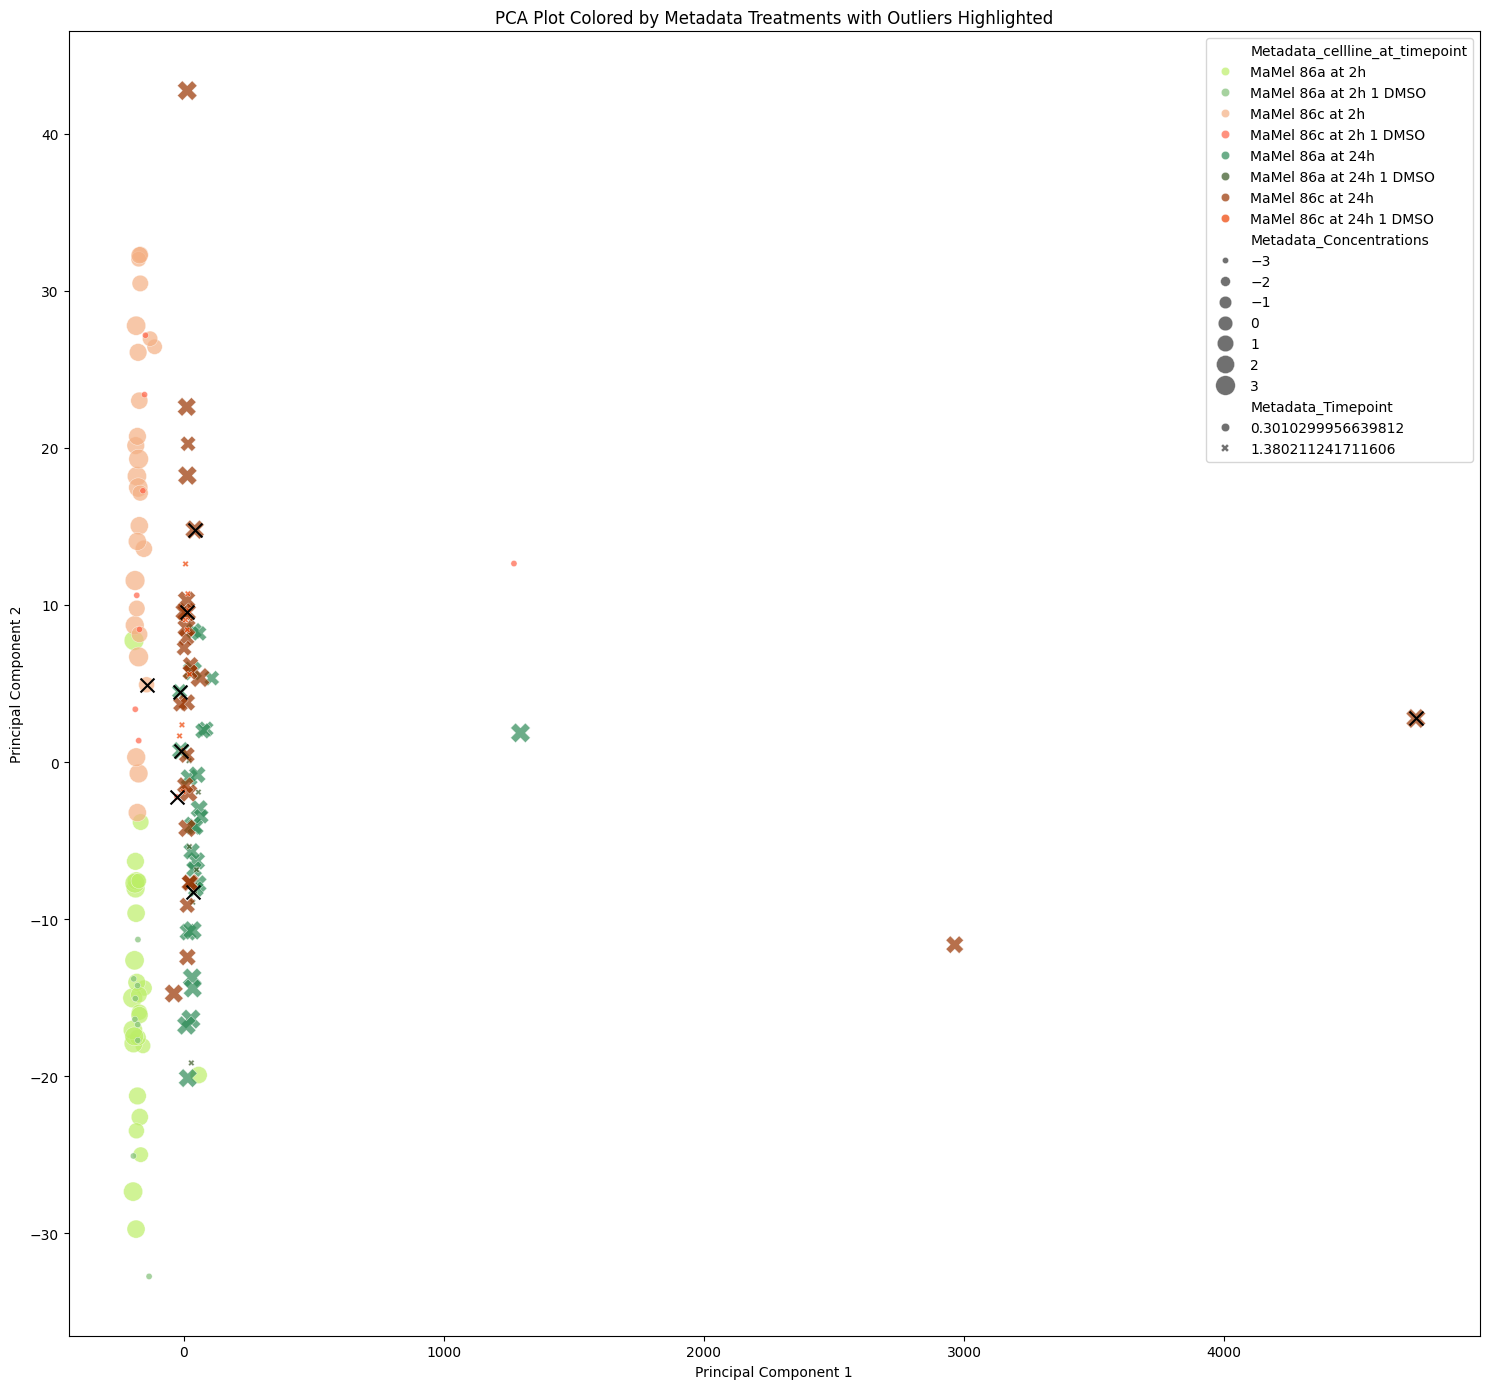

In [31]:
# Plotting
plt.figure(figsize=(15, 14))
sns.scatterplot(
    data=pca_df,
    x="PC1", 
    y="PC2",
    hue="Metadata_cellline_at_timepoint",
    palette=color_dict,
    size="Metadata_Concentrations",
    sizes=(20, 200),
    style = "Metadata_Timepoint",
    alpha=0.7
)

# Highlight outliers
outliers = pca_df[pca_df['Outlier'] == -1]
plt.scatter(outliers['PC1'], outliers['PC2'], color="black", edgecolor='black', label='Outliers', s=100, marker='x')

plt.title("PCA Plot Colored by Metadata Treatments with Outliers Highlighted")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.savefig("PCA+outlier.png")
#plt.grid()
#plt.close()

In [32]:
df["Metadata_Outliers"] = list(pca_df['Outlier'])
#df.loc[df["Metadata_Cellline"] != "Baseline: DMSO" , "Metadata_Outliers"] = 1

In [33]:
df = df[df["Metadata_Outliers"] == 1]
print(df.shape)

(136, 162)


In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print(df.shape)
# Calculate the variance of each feature
# Initialize the MinMaxScaler
scaler = StandardScaler()
df[cellranger_feats] = scaler.fit_transform(df[cellranger_feats])
scaler = MinMaxScaler()
df[cellranger_feats] = scaler.fit_transform(df[cellranger_feats])
# Fit and transform the cellranger columns

#df.head()
#print(df.shape)

(136, 162)


In [35]:
for channel, features in feat_dict.items():
    print(f"{channel}: {len(features)}")

Channel: DNA: 35
Channel: Mito: 44
Channel: RNA: 10
Channel: ER: 26
Channel: AGP: 10
Interchannel Object: Image: 2
Interchannel Object: Cells: 6
Interchannel Object: Cytoplasm: 3
Interchannel Object: Nuclei: 8


In [36]:
# Invert feat_dict
inverted_feat_dict = {}
for channel, features in feat_dict.items():
    for feature in features:
        inverted_feat_dict[feature] = channel

In [37]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import shap
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from scipy import stats
from joblib import Parallel, delayed

def perform_anova(feature, X, y):
    """Function to perform one-way ANOVA for a given feature."""
    group_data = [X[feature][y == label] for label in np.unique(y)]
    f_stat, p_value = stats.f_oneway(*group_data)
    return {'Feature': feature, 'F-statistic': f_stat, 'Anova p-value': p_value}

def perm_importance(X: pd.DataFrame, cellranger_feats, label_col: str, inverted_feat_dict: dict) -> pd.DataFrame:
   
    label_encoder = LabelEncoder()
    X[label_col] = label_encoder.fit_transform(X[label_col])
    y = X[label_col]  # Target variable

    # Step 2: Prepare the features and target variable
    X = X[cellranger_feats]  

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Step 3: Train a CatBoost Classifier
    #model = CatBoostClassifier(random_state=42, verbose=0)  # Set verbose=0 to suppress output during training
    #model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    #y_hat = model.predict(X_test)
    #report = classification_report(y_test, y_hat)
    #print("Classification Report:")
    #print(report)



    
    # Chi-squared statistics
    chi2_stats, p_values = chi2(X, y)
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Chi2 Statistic': chi2_stats})
    feature_importances["Type Feature"] = [inverted_feat_dict[x] for x in feature_importances["Feature"]]
    
    feature_importances["Chi2 Statistic"] = chi2_stats
    feature_importances["Chi2 p-value"] = p_values
    feature_importances["Rank Chi2"] = feature_importances["Chi2 Statistic"].rank(ascending=False)

    # Logistic Regression for feature importance
    log_reg = LogisticRegression(max_iter=1000, penalty=None)
    log_reg.fit(X_train, y_train)
    coefficients = log_reg.coef_[0]  # Get the coefficients for the first class
    y_hat = log_reg.predict(X_test)
    report = classification_report(y_test, y_hat)
    print("Classification Report Logreg:")
    print(report)
    feature_importances["Logistic Coefficient"] = coefficients
    feature_importances["Rank Logistic"] = feature_importances["Logistic Coefficient"].rank(ascending=False)

    # Perform One-Way ANOVA for each continuous feature in parallel
    anova_results = Parallel(n_jobs=-1)(  # Use all available cores
        delayed(perform_anova)(feature, X, y) for feature in X.columns if np.issubdtype(X[feature].dtype, np.number)
    )

    anova_df = pd.DataFrame(anova_results)
    feature_importances = feature_importances.merge(anova_df, on='Feature', how='left')

    # Apply Bonferroni correction
    num_tests = len(anova_df)
    feature_importances['Bonferroni adjusted Anova p-value'] = feature_importances['Anova p-value'] * num_tests
    feature_importances['Bonferroni adjusted Anova p-value'] = feature_importances['Bonferroni adjusted Anova p-value'].clip(upper=1.0)  # Cap at 1.0
    
    num_tests = len(anova_df)
    feature_importances['Bonferroni adjusted Chi2 p-value'] = feature_importances['Chi2 p-value'] * num_tests
    feature_importances['Bonferroni adjusted Chi2 p-value'] = feature_importances['Bonferroni adjusted Chi2 p-value'].clip(upper=1.0)  # Cap at 1.0
    

    # Sort the features by importance
    feature_importances = feature_importances.sort_values(by='Chi2 Statistic', ascending=False)
    
    # Scale the SHAP feature importances to a 0 to 1 range
    scaler = MinMaxScaler()
    
    return feature_importances,  None

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [38]:
feature_importances_allVSall, explainer_all_vs_all = perm_importance(
    df.copy(),
    cellranger_feats,
    "Metadata_Cellline",
    inverted_feat_dict
)

Classification Report Logreg:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.75      0.86         4
           2       0.90      0.90      0.90        10
           3       0.67      0.67      0.67         3

    accuracy                           0.89        28
   macro avg       0.87      0.83      0.85        28
weighted avg       0.90      0.89      0.89        28



In [39]:
df["Metadata_cellline_at_timepoint"].unique()

array(['MaMel 86a at 2h', 'MaMel 86a at 2h 1 DMSO', 'MaMel 86c at 2h',
       'MaMel 86c at 2h 1 DMSO', 'MaMel 86a at 24h',
       'MaMel 86a at 24h 1 DMSO', 'MaMel 86c at 24h',
       'MaMel 86c at 24h 1 DMSO'], dtype=object)

In [40]:
feature_importances = []
shap_values_list = []
explainers = []
treatments_feat_imp = [
    'MaMel 86c at 2h',
    'MaMel 86c at 24h',
    'MaMel 86a at 2h',
    'MaMel 86a at 24h',
    'MaMel 86c at 2h',
    'MaMel 86c at 24h',
    'MaMel 86a at 2h',
    'MaMel 86a at 24h',
]
controls = [
    'MaMel 86c at 24h',
    'MaMel 86c at 2h',
    'MaMel 86c at 2h',
    'MaMel 86c at 24h',
    'MaMel 86c at 2h DMSO',
    'MaMel 86c at 24h DMSO',
    'MaMel 86a at 2h DMSO',
    'MaMel 86a at 24h DMSO',
]

In [41]:
for treatment, control in zip(treatments_feat_imp, controls):
    print(f"Processing {treatment} vs. {control}")

    try:
        feature_importance,  explainer = perm_importance(
            df[df["Metadata_cellline_at_timepoint"].isin([treatment, control])].copy(),
            cellranger_feats,
            "Metadata_cellline_at_timepoint",
            inverted_feat_dict
        )
        feature_importances.append(feature_importance)
        explainers.append(explainer)
    except:
        continue

Processing MaMel 86c at 2h vs. MaMel 86c at 24h
Classification Report Logreg:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Processing MaMel 86c at 24h vs. MaMel 86c at 2h
Classification Report Logreg:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Processing MaMel 86a at 2h vs. MaMel 86c at 2h
Classification Report Logreg:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
    

In [42]:
n_features = 30
feature_importances = [feature_importances_allVSall] + feature_importances
explainers = [explainer_all_vs_all] + explainers
treatments_feat_imp = ["All"] + treatments_feat_imp
controls = ["All"] + controls

In [43]:
import numpy as np
df["Metadata_Concentrations_log"] = np.log10(df["Metadata_Concentrations"].astype(float))
df = df.copy()


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [44]:
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and feature_importances is defined
# Select the top 10 features

def top_feat2umap(X, feat_imp, n_features, treatment, control, color_dict):
    top_features = list(feat_imp[:n_features]["Feature"])
    data_to_umap = X[top_features]

    # Perform UMAP
    umap_model = umap.UMAP()
    umap_results = umap_model.fit_transform(data_to_umap)

    # Create a new DataFrame for UMAP results
    umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'])
    umap_df['Metadata_Cellline'] = df['Metadata_Cellline']
    umap_df['Metadata_Concentrations_log'] = df['Metadata_Concentrations_log']
    umap_df['Metadata_Timepoint'] = df['Metadata_Timepoint']


    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=umap_df,
        x='UMAP1',
        y='UMAP2',
        hue='Metadata_Cellline',
        palette=color_dict,
        size='Metadata_Concentrations_log',
        style="Metadata_Timepoint"
        #alpha=0.7
    )
    plt.title(f"UMAP of Top {n_features} Features from classification {treatment} vs. {control}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.savefig(f"UMAP_{treatment}_vs_{control}_top_{n_features}_feat.png", dpi=300)
    plt.close()
    plt.close()


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_feat_imp(df, color_dict, feature_importance, feat_imp, feature, treatment, control, color_dict_channels, added_str="", n: int = 20, p_value_column=None):
    
    fig, axes = plt.subplots(ncols=2, figsize=(17, int(n / 2)))
    feature_importance.sort_values(feat_imp, ascending=False, inplace=True)
    
    if p_value_column:
        feature_importance = feature_importance[feature_importance[p_value_column] <= 0.05]
        number_relevant_features = feature_importance.shape[0]
        if feature_importance.shape[0] < n:
            n = feature_importance.shape[0]
            if n <= 1:
                print(f"No significant features with {feat_imp}")
                return

    feature_importance = feature_importance[:n].reset_index()
    df = df[df["Metadata_Concentrations"] >= 1]
    df = df[list(feature_importance["Feature"]) + ["Metadata_cellline_at_timepoint"]]

    
    # Create the bar plot
    sns.barplot(
        data=feature_importance,
        x=feat_imp,
        y=feature,
        hue="Type Feature",
        palette=color_dict_channels,
        alpha=0.6,
        ax=axes[0]
    )
    
    if p_value_column:
        # Annotate bars with p-values
        for index, row in feature_importance.iterrows():
            axes[0].text(
                row[feat_imp] + 0.1,  # Adjust the position slightly to the right of the bar
                index,
                f' p={row[p_value_column]:.1e}',  # Format p-value to scientific notation
                color='black',
                va='center'  # Vertically center the text
            )
        # Add a textbox with the count of columns under the threshold
        textbox_str = f'Number of Features under Bonferroni adjusted threshold of 0.05: {number_relevant_features}'
        plt.text(0.1, -0.1, textbox_str, ha='center', va='center', transform=axes[0].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
            
    # Remove the right and top spines
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    
    # Melt the DataFrame
    long_form_df = pd.melt(
        df, 
        id_vars=['Metadata_cellline_at_timepoint'],  # Columns to keep as identifier variables
        var_name='Feature',               # Name for the variable column
        value_name='Value Normalised'
    )
    
    # Set the order of the 'Feature' column based on feature_list
    long_form_df['Feature ordered'] = pd.Categorical(
        long_form_df['Feature'],
        categories=list(feature_importance["Feature"]),
        ordered=True
    )

    # Sort the DataFrame by the 'Feature' column
    sorted_long_form_df = long_form_df.sort_values(by='Feature ordered')
    
    # Create the violin plot
    sns.stripplot(
        data=long_form_df,
        x="Value Normalised",
        y="Feature",
        hue="Metadata_cellline_at_timepoint",
        palette=color_dict,
        ax=axes[1],
        dodge=True,
        alpha=0.25,
        zorder=1,
        legend=False,
        jitter=False,
    )
    
    sns.pointplot(
        data=long_form_df,
        hue='Metadata_cellline_at_timepoint',
        x="Value Normalised",
        y="Feature",
        palette=color_dict,
        ax=axes[1],
        dodge=.8 - .8 / 3,
        linestyle="none",
        legend=True
    )

    # Add horizontal lines between each feature in the bar plot
    #for i in range(len(feature_importance)):
    #    axes[1].hlines(i-0.5, xmin = 0, xmax = 1, color='gray', linewidth=0.7, alpha = 0.5)

    axes[1].grid(False)
    axes[1].yaxis.set_visible(False) 
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)

    # Move legends outside the bottom of the plot
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Adjust ncol for legend layout
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Adjust ncol for legend layout

    axes[0].set_title(f"Top {n} Features by {feat_imp} for {treatment} vs. {control}")
    #plt.tight_layout()  # Adjust layout to prevent clipping of text
    plt.subplots_adjust(left=0.3) # Adjust the bottom margin as needed
    plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin as needed


    plt.savefig(f"feature_imp_{treatment}vs{control}_{feat_imp}_{added_str}.png", dpi = 300)
    #
    # plt.close()

No significant features with F-statistic
No significant features with F-statistic


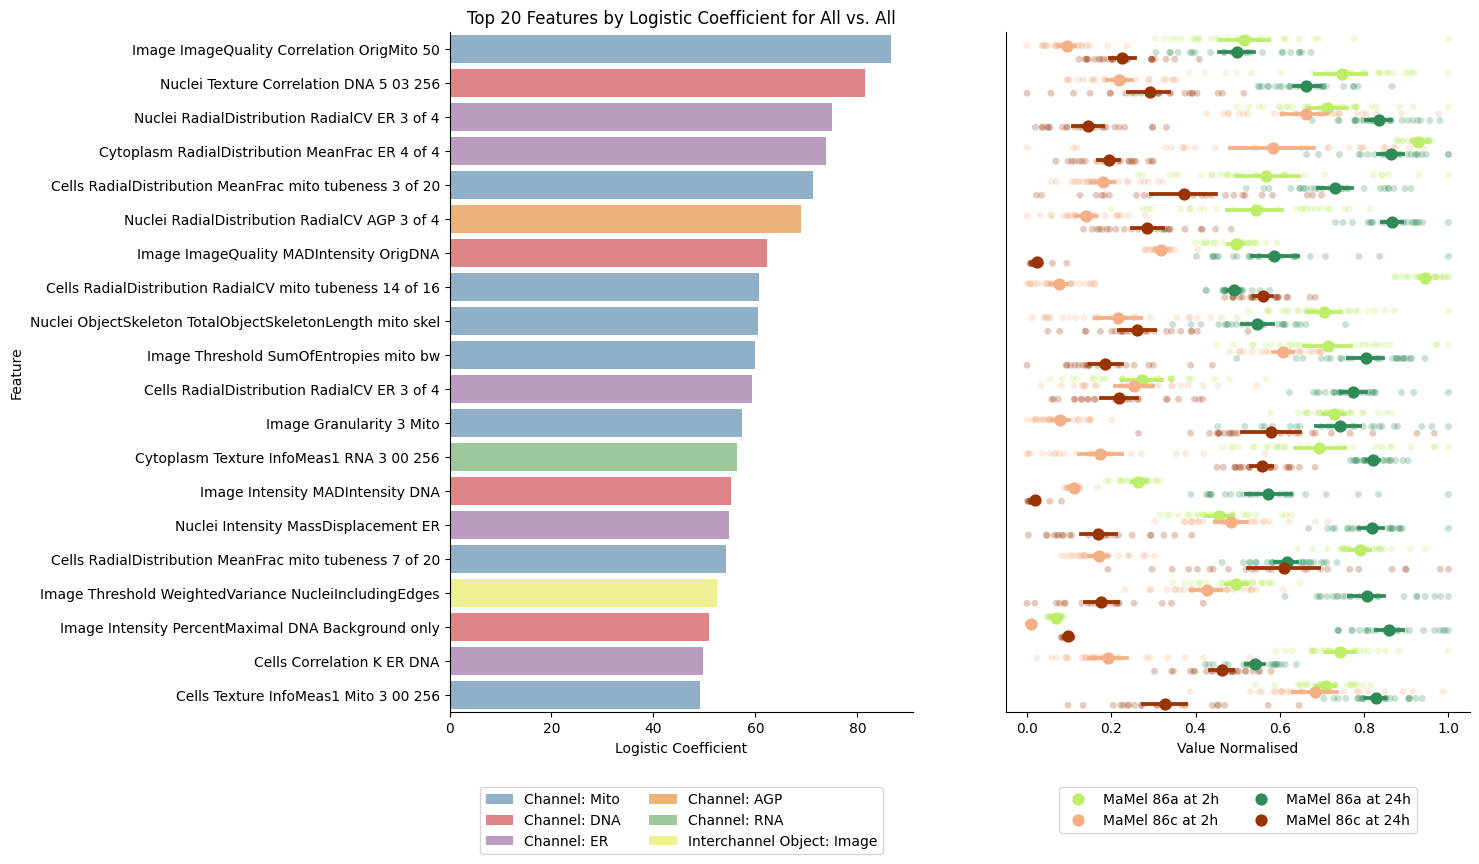

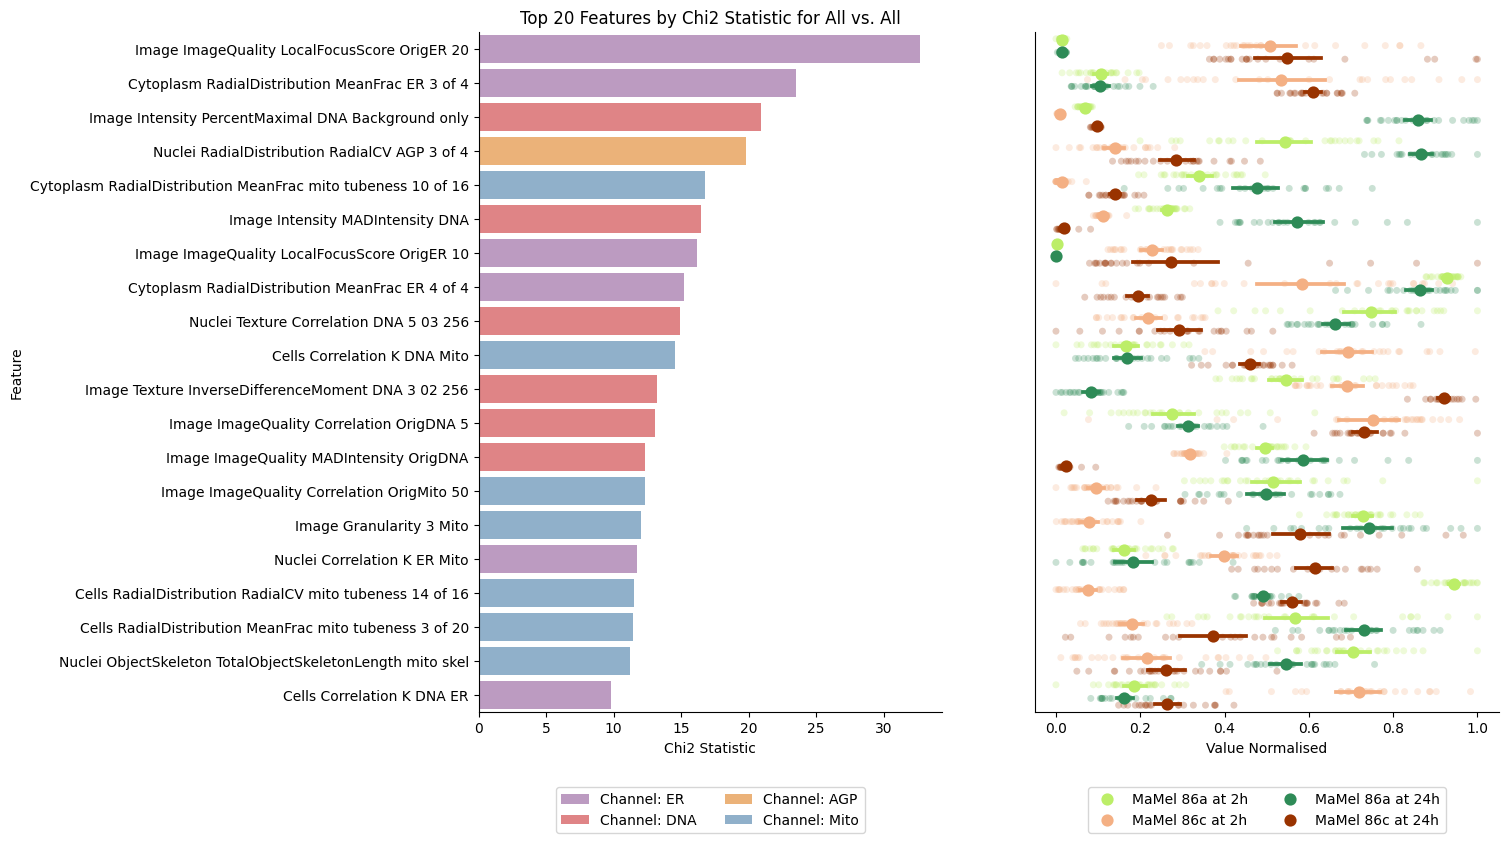

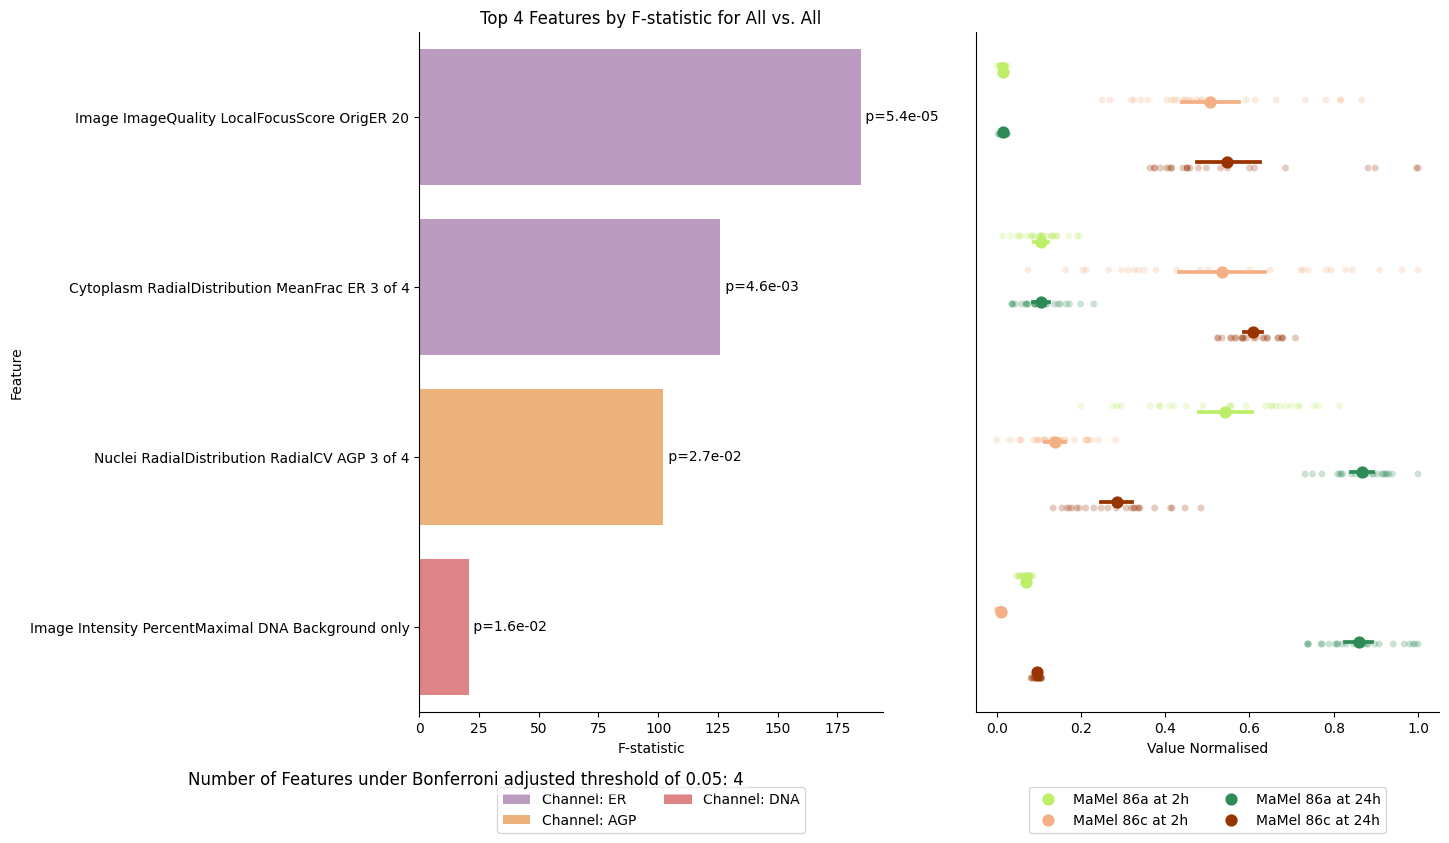

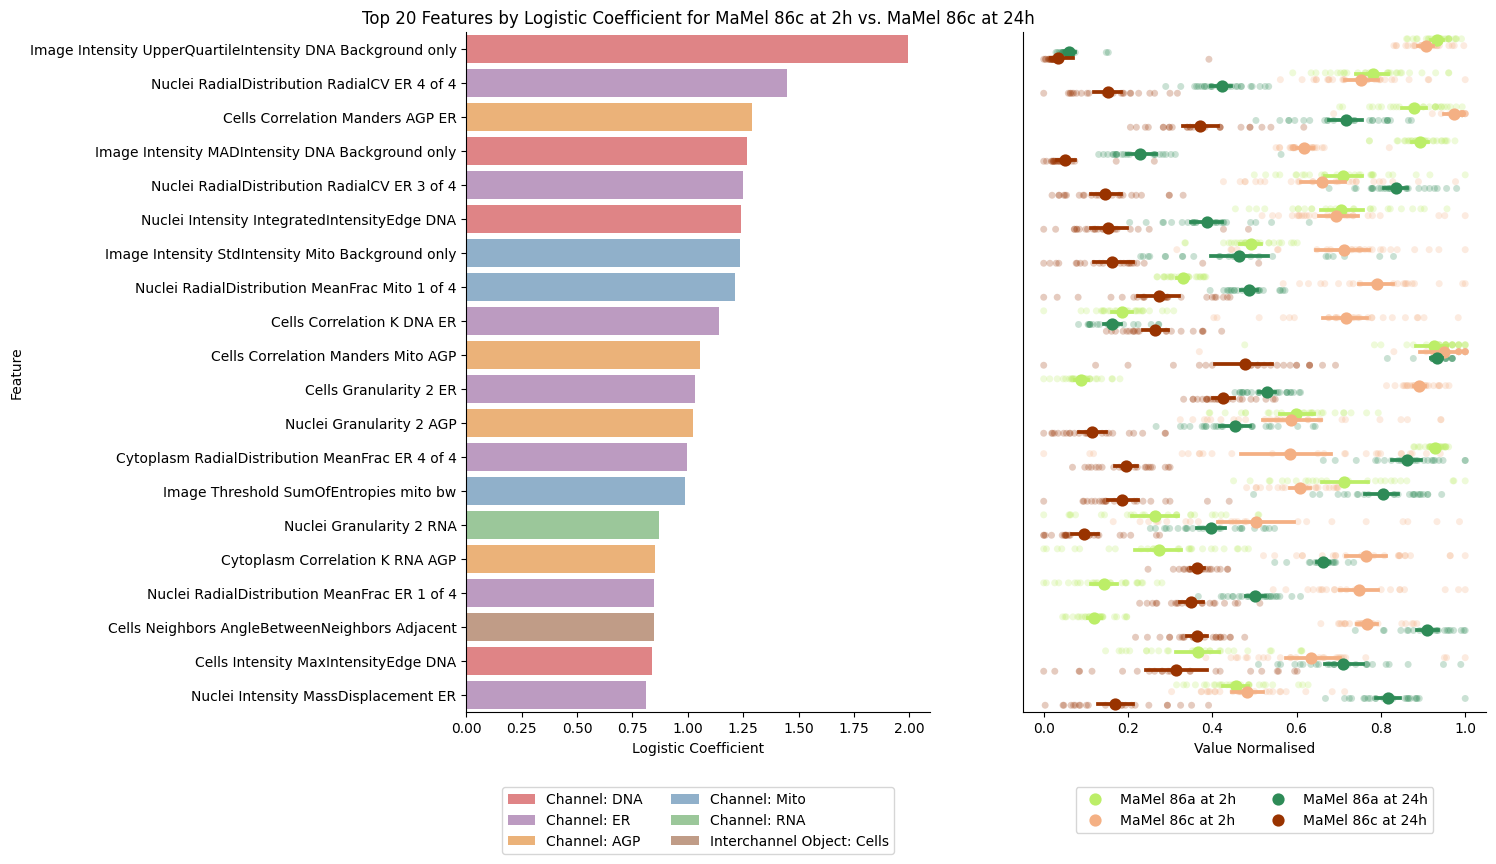

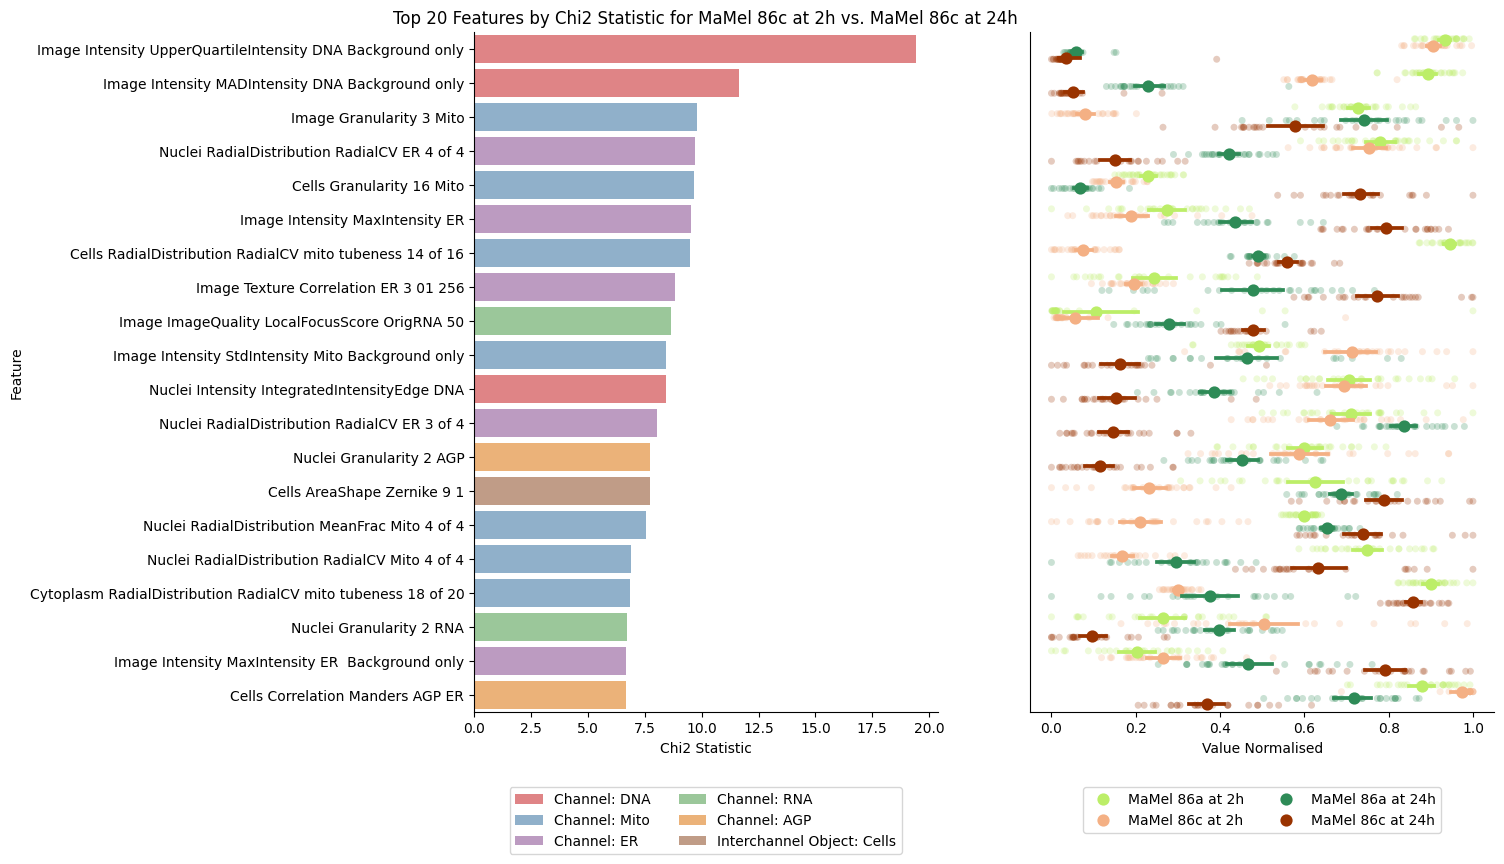

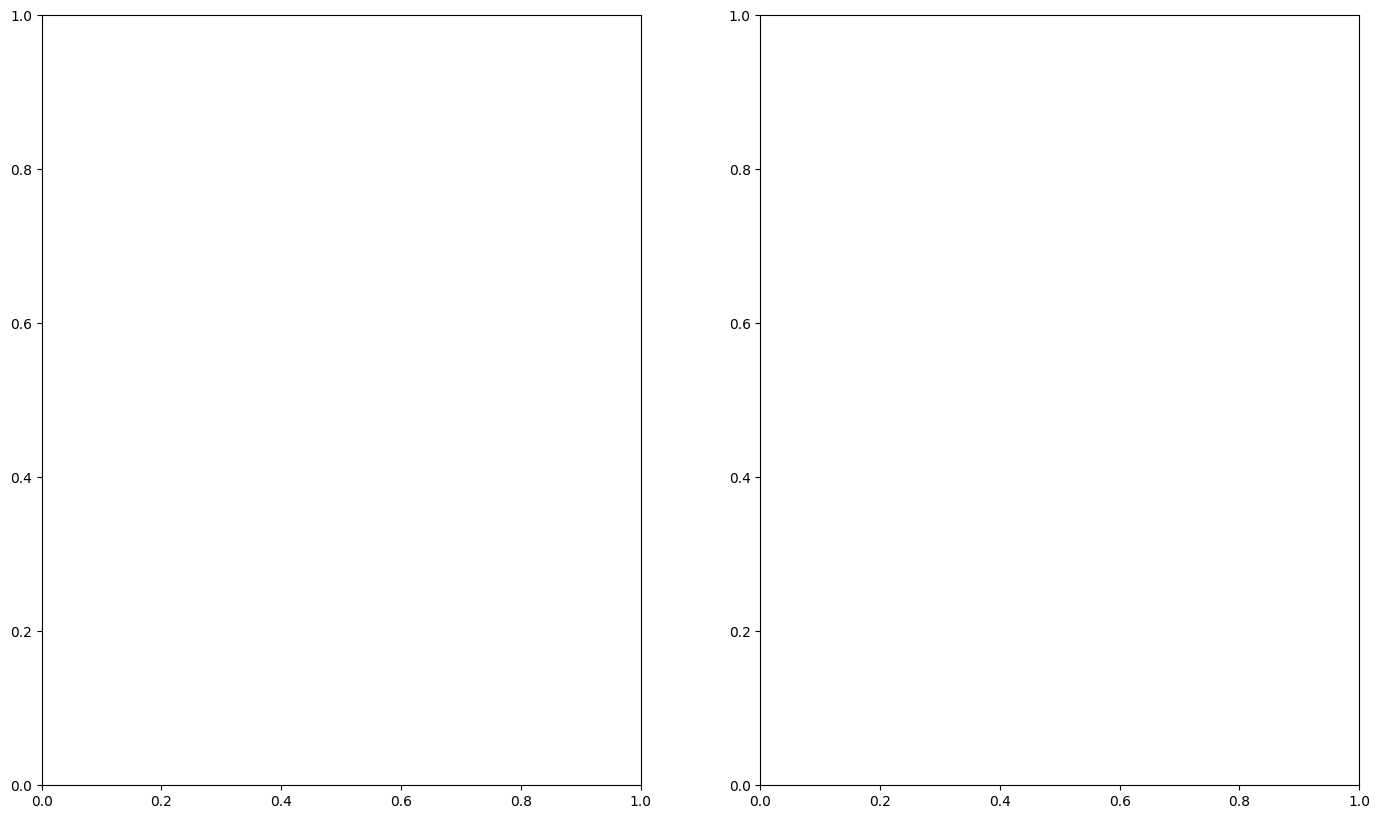

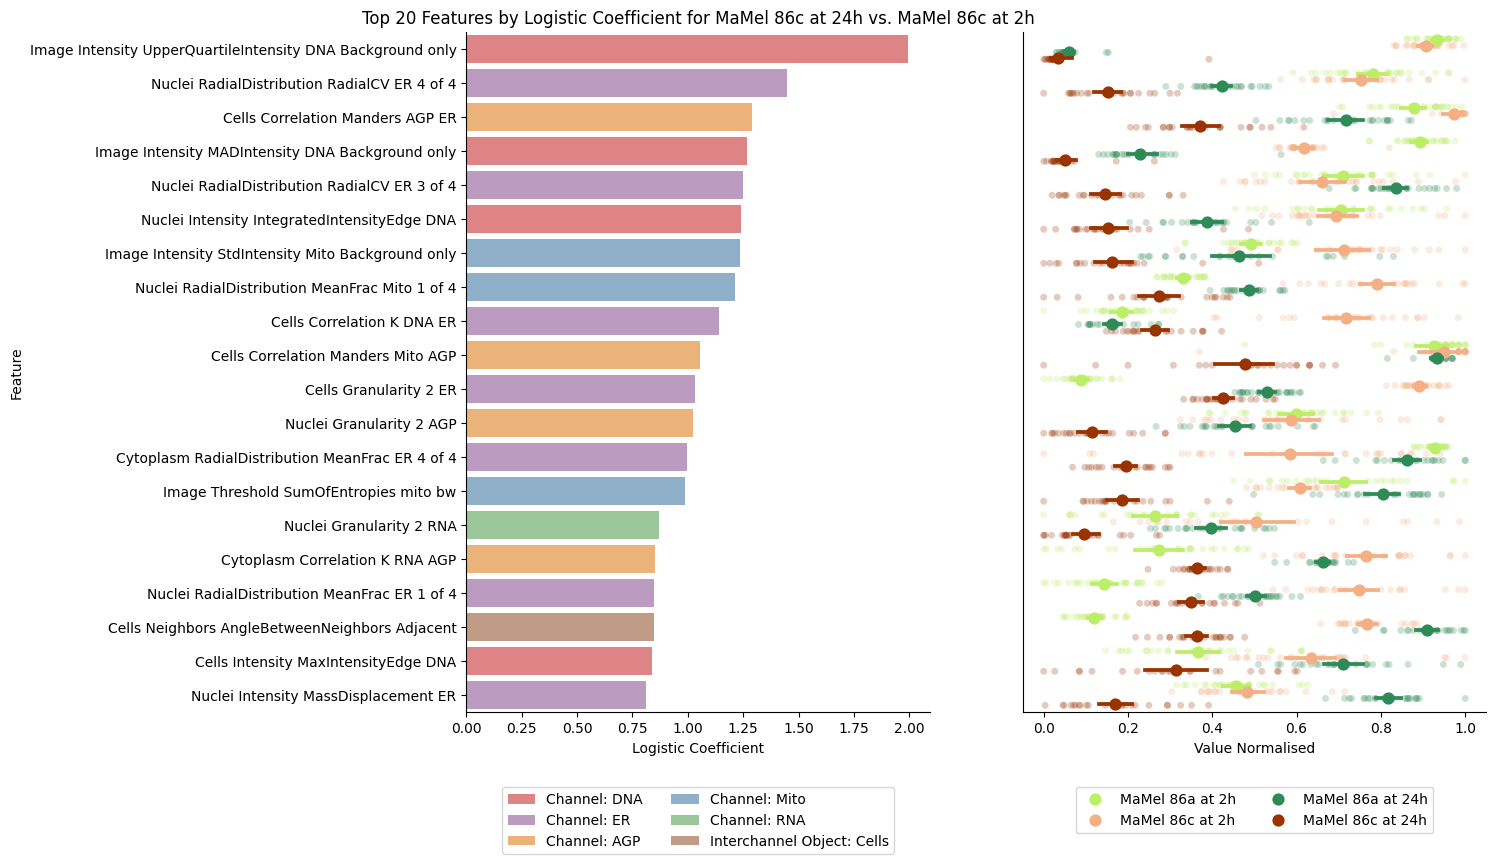

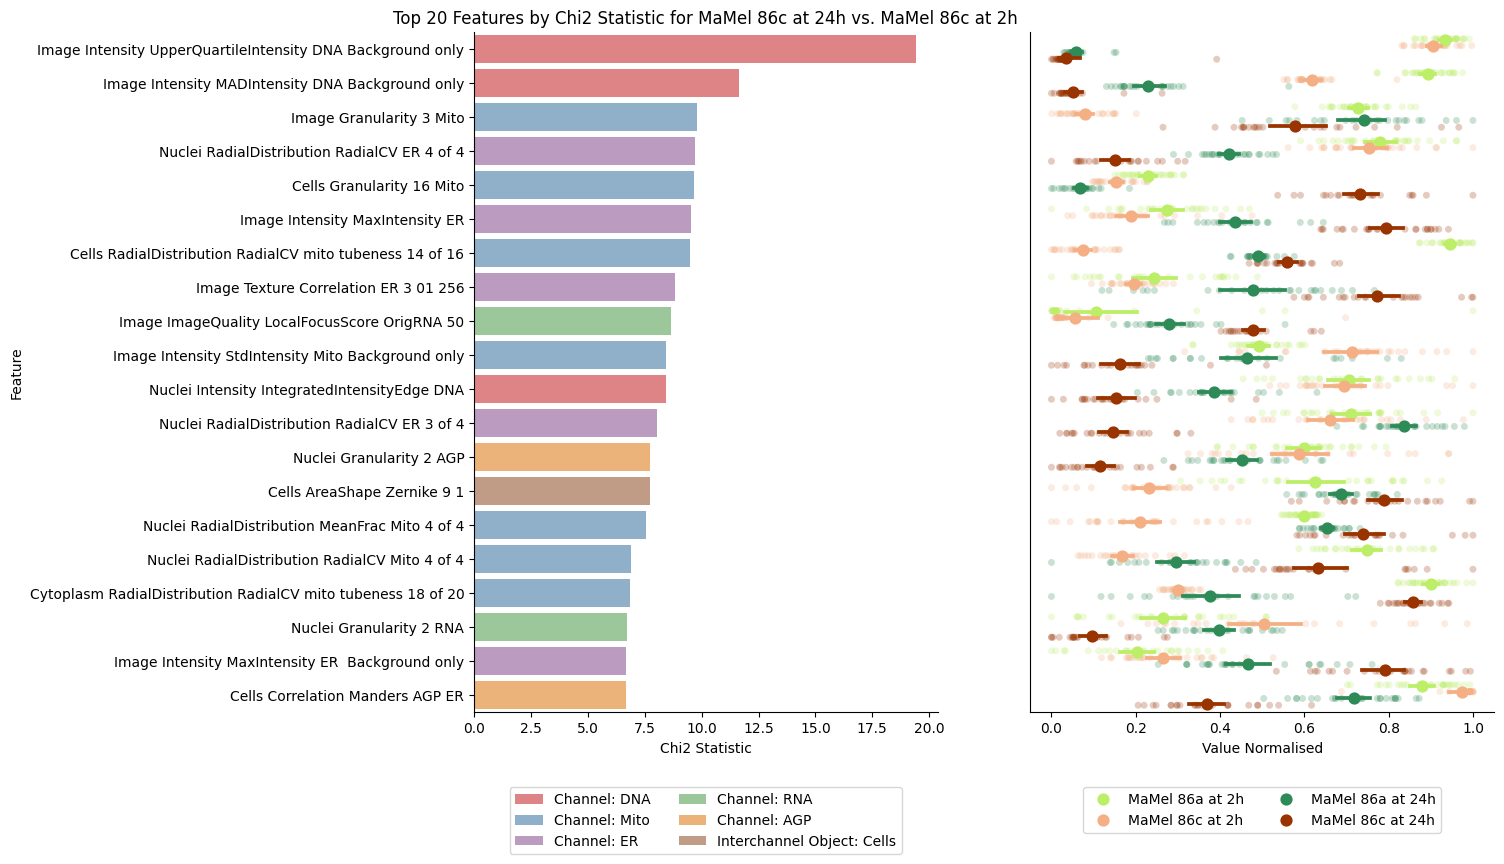

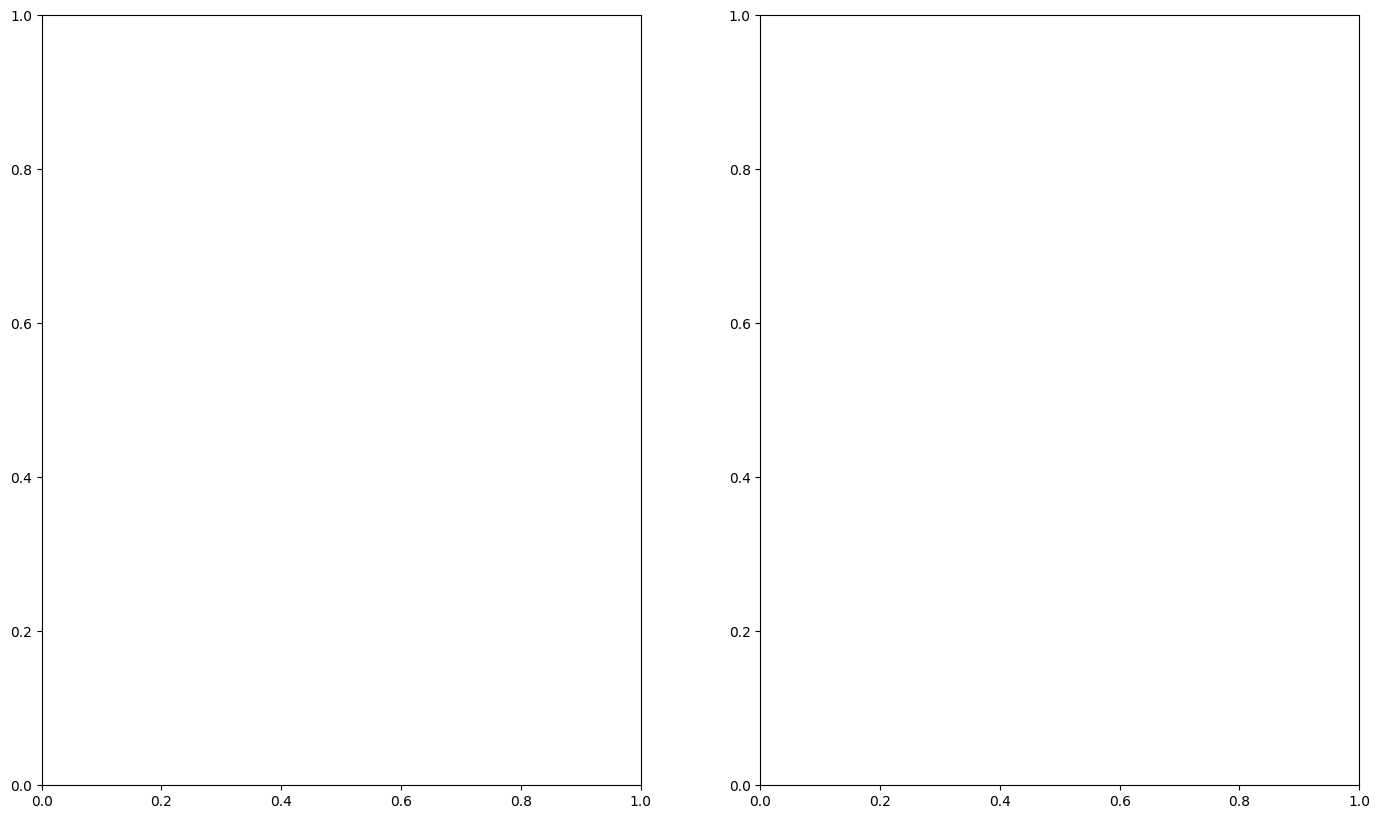

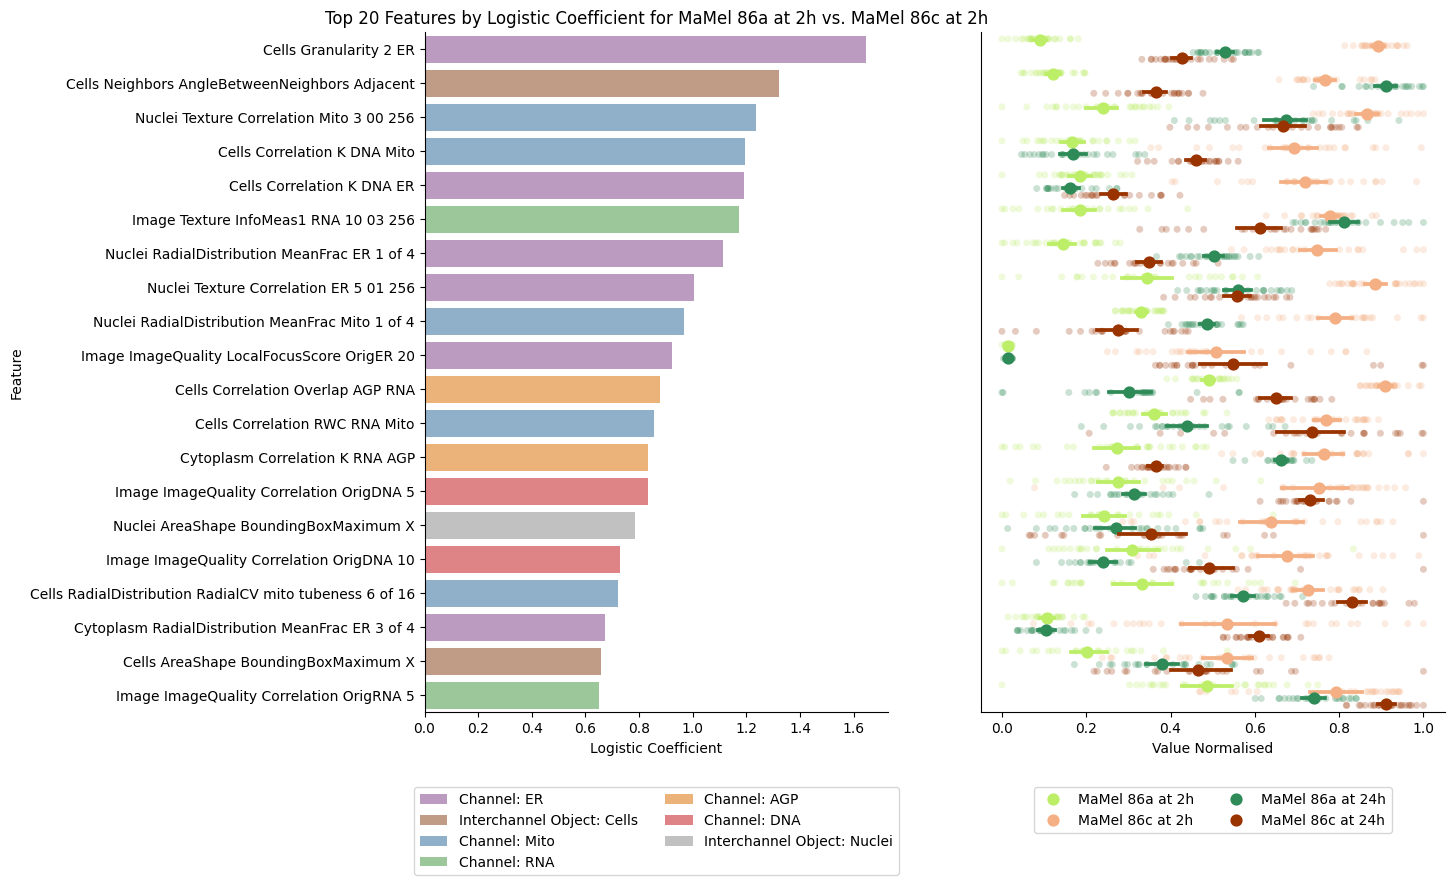

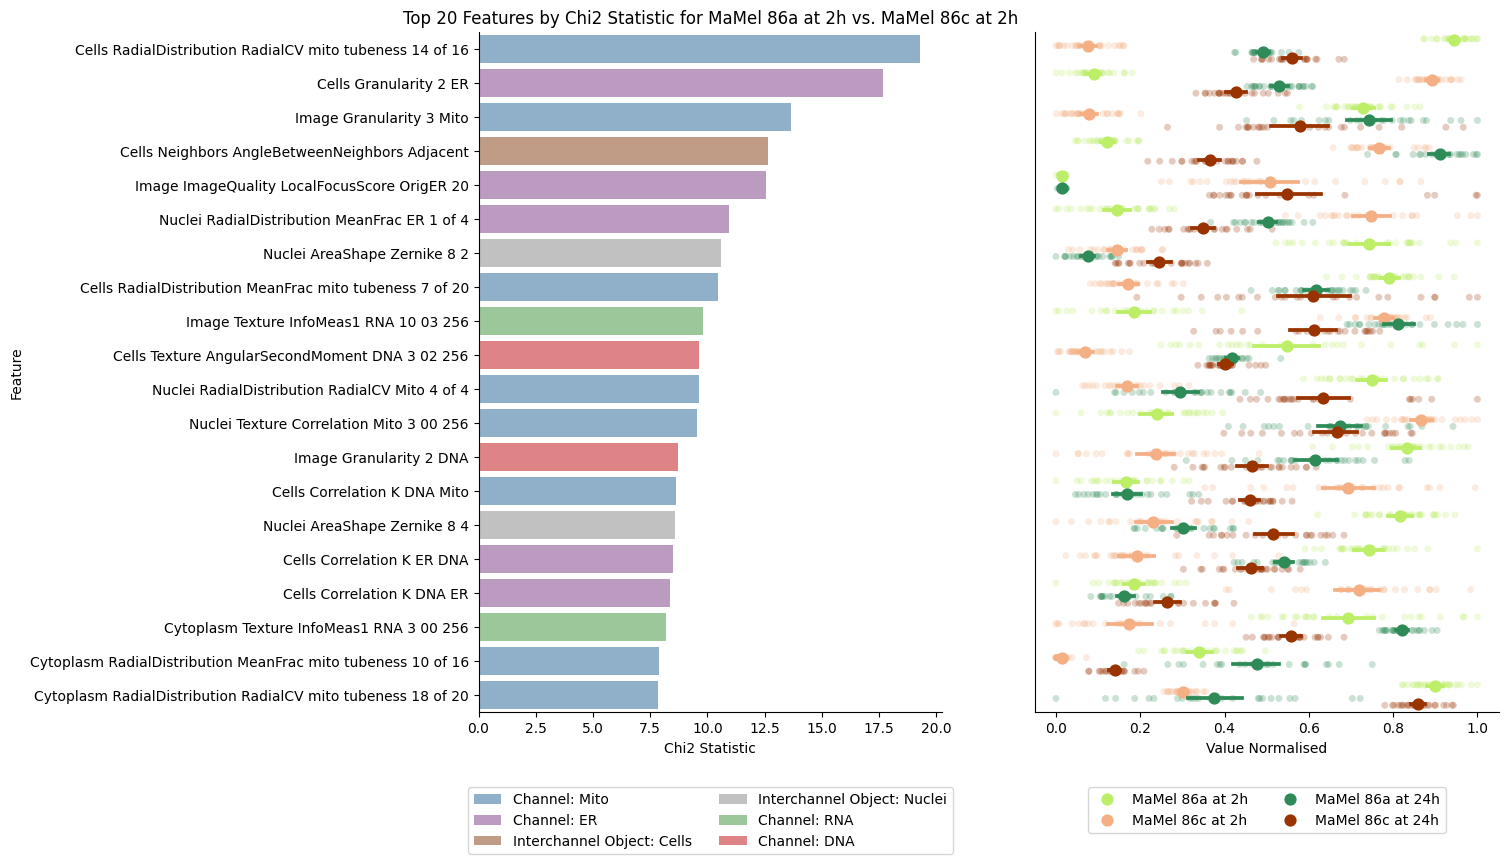

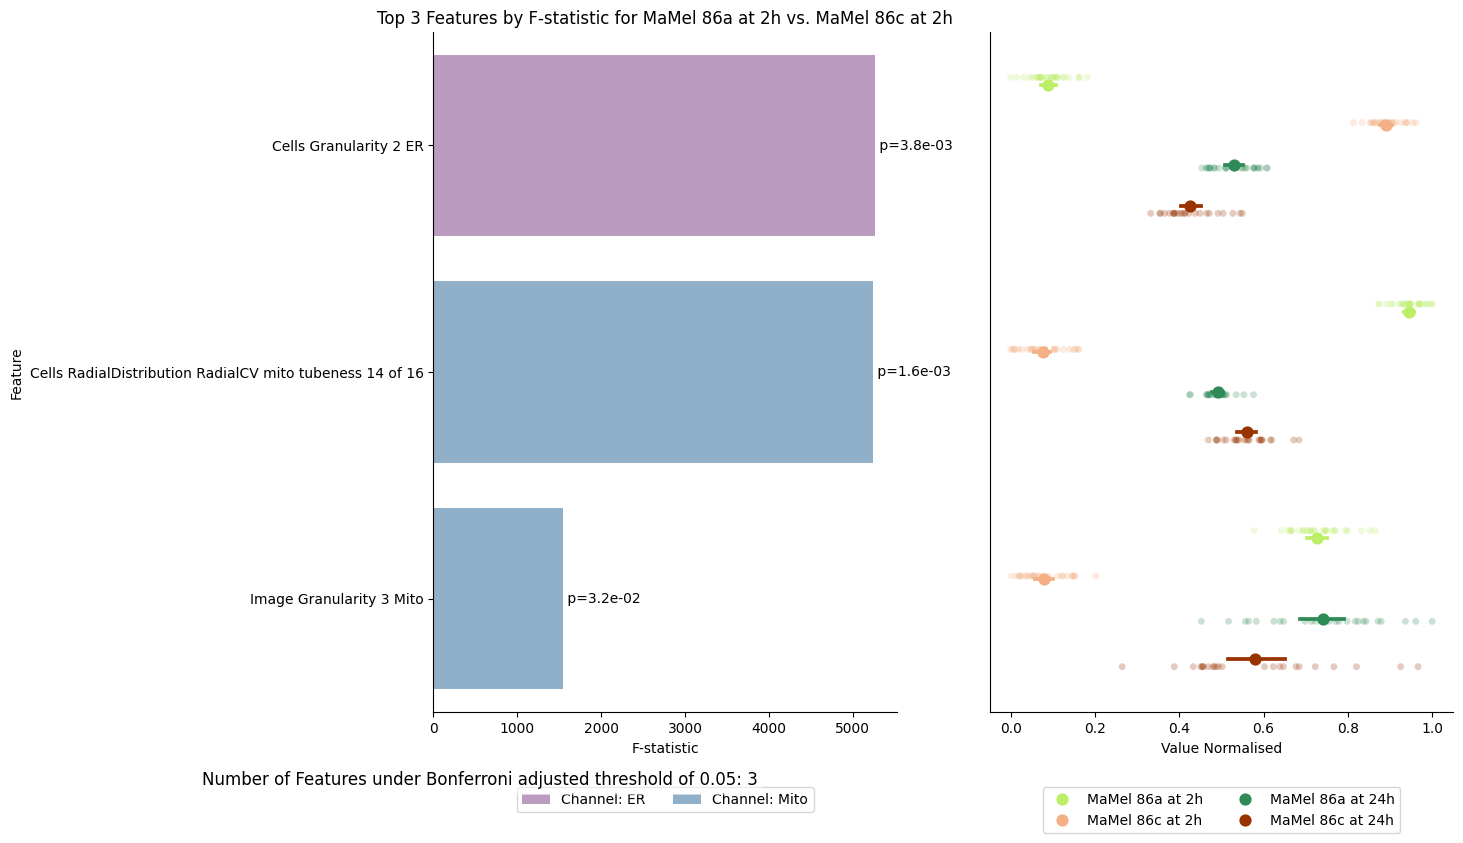

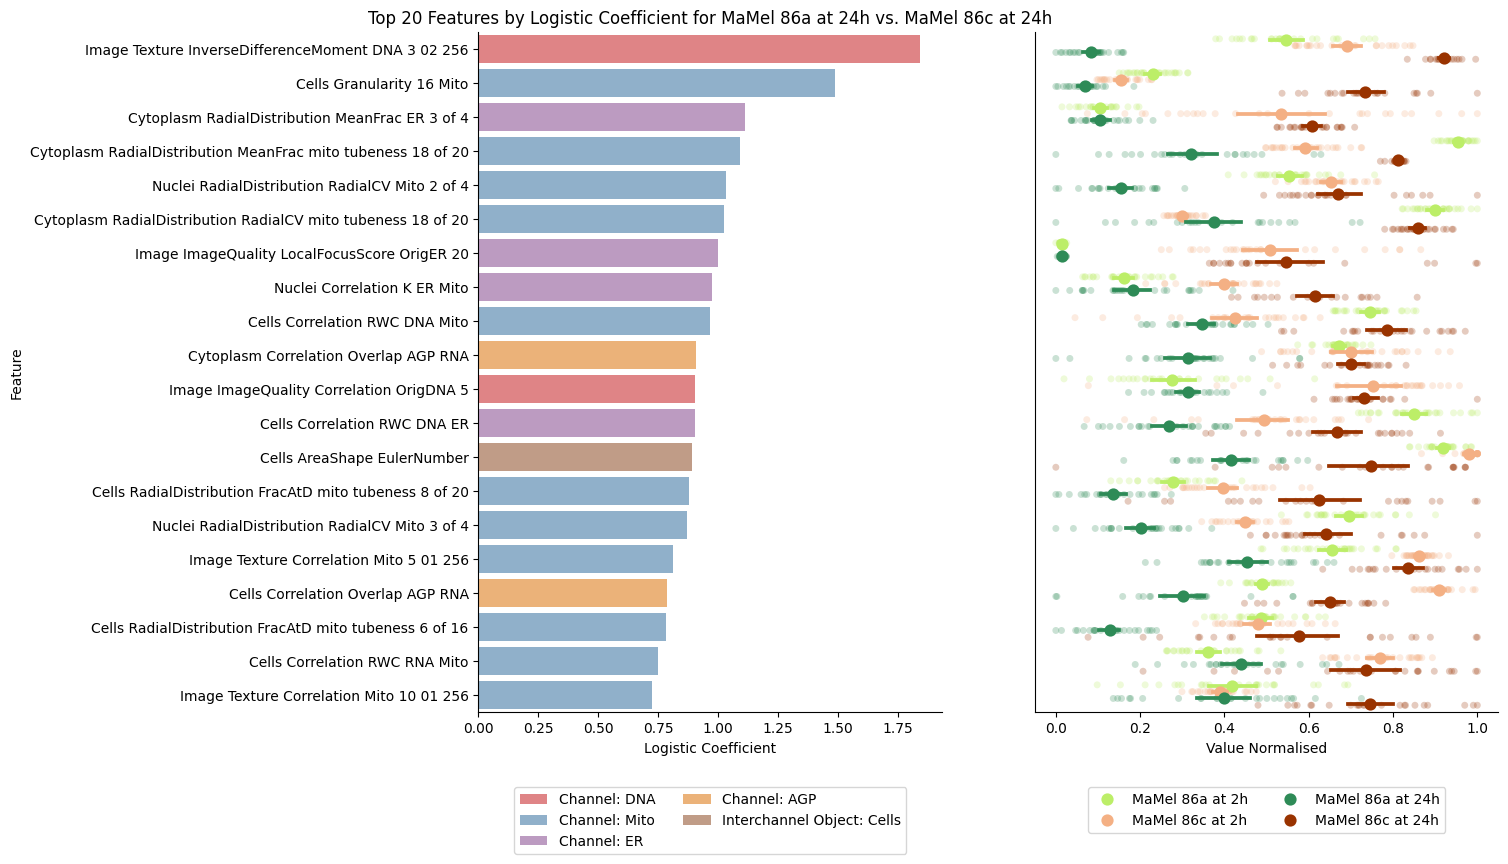

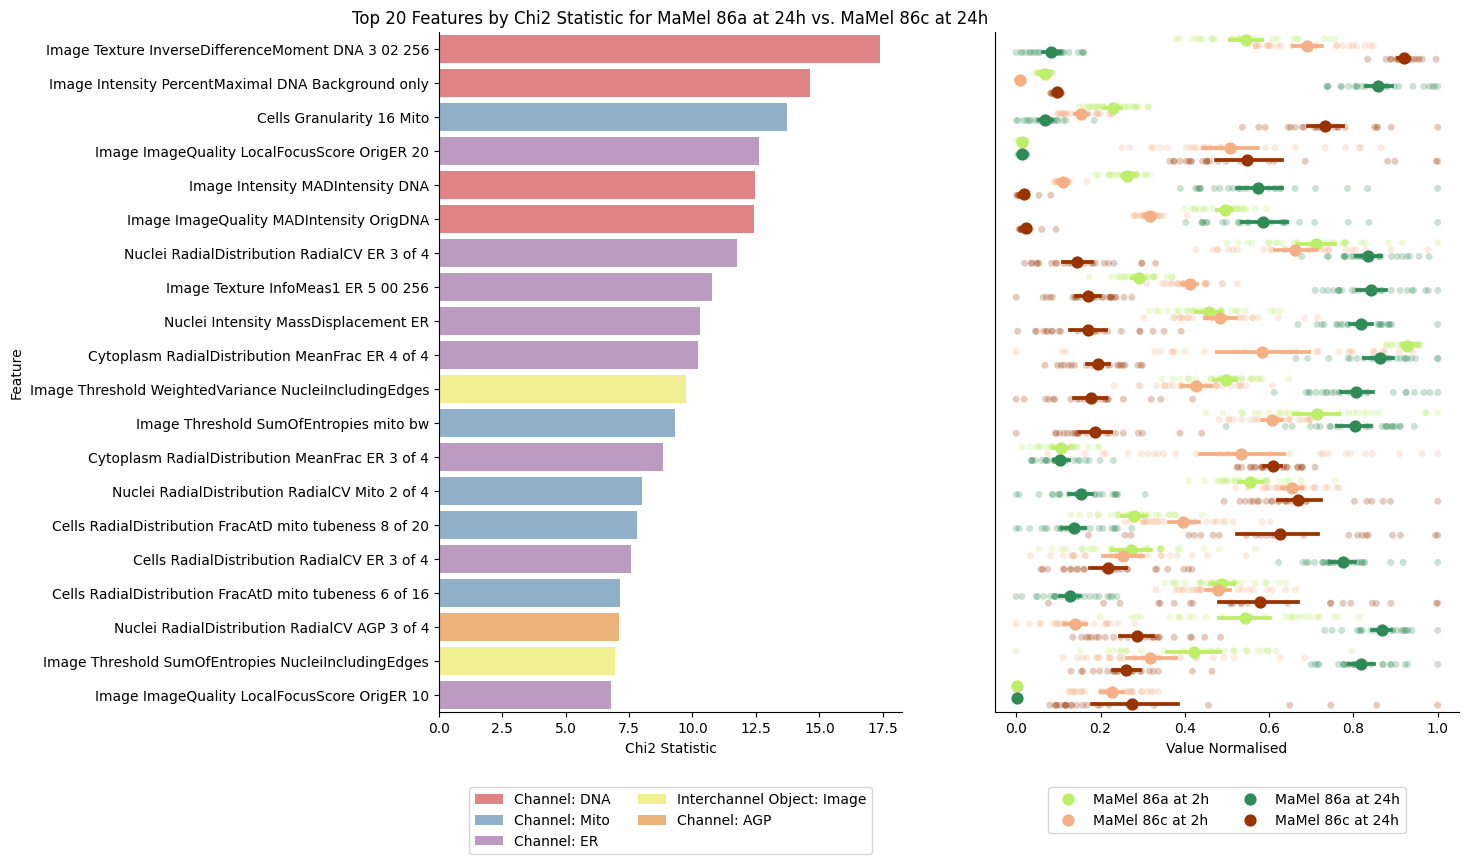

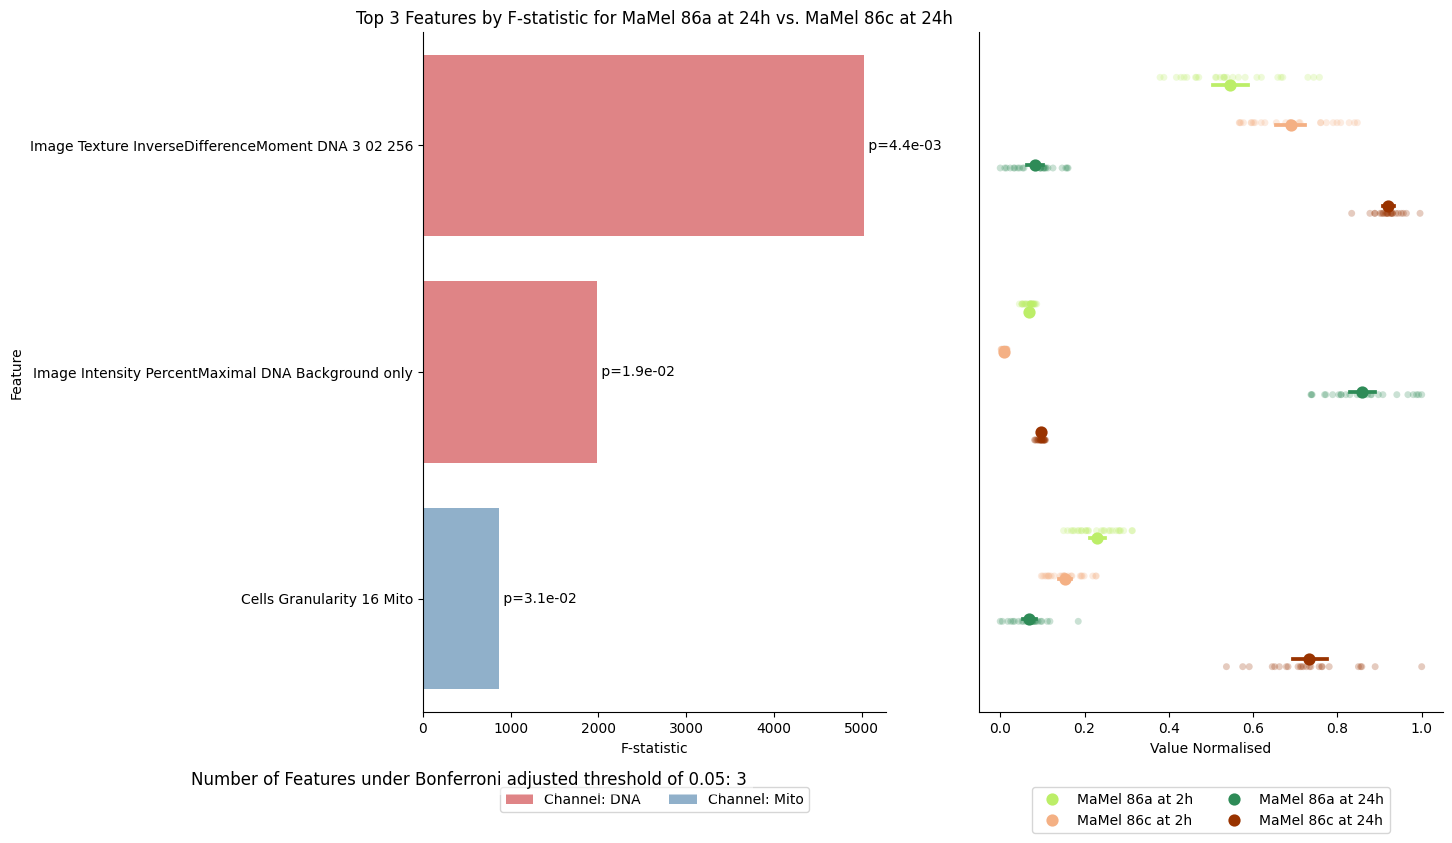

In [46]:
n_features = 20
feat_imps = [
    "Logistic Coefficient",
    "Chi2 Statistic",
    "F-statistic"
]
p_palue_columns = [
    None,
    None,
    "Bonferroni adjusted Chi2 p-value",
    "Bonferroni adjusted Anova p-value"
]

for treatment, feature_importance, control in zip(treatments_feat_imp,  feature_importances, controls):
    for type_feat_imp, p_value_column in zip(feat_imps, p_palue_columns):
        plot_feat_imp(
            df[cellranger_feats + ["Metadata_cellline_at_timepoint", "Metadata_Concentrations"]].copy(),
            color_dict,
            feature_importance,
            type_feat_imp, 
            "Feature",
            treatment, 
            control,
            color_dict_channels,
            "",
            n_features,
            p_value_column)

In [47]:
feature_imp_of_choice="F-statistic"

for feature_importance in feature_importances:
    feature_importance.sort_values(feature_imp_of_choice,ascending = False, inplace = True)

In [48]:
#for treatment, feature_importance, control in zip(treatments_feat_imp, feature_importances, controls):
#    top_feat2umap(df.copy(), feature_importance, 50, treatment, control, color_dict)

In [49]:
#for treatment, feature_importance, control in zip(treatments_feat_imp, feature_importances, controls):
#    feature_importance_grouped = feature_importance.groupby('Type Feature').sum().reset_index()
#    for type_feat_imp in feat_imps:
#        plot_feat_imp(
#            df[cellranger_feats + ["Metadata_Cellline", "Metadata_Concentrations"]].copy(),
#            color_dict,
#            feature_importance_grouped,
#            type_feat_imp,
#            "Type Feature",
#            treatment,
#            control,
#            color_dict_channels,
#            "grouped_by_channel",
#            feature_importance_grouped.shape[0],
#            None)
#    break

In [50]:
#for treatment, feature_importance, control in zip(treatments_feat_imp, feature_importances, controls):
#    for channel in feat_dict.keys():
#        plot_feat_imp(feature_importance[feature_importance["Type Feature"]==channel], "Feature", treatment, control, channel, n_features)
#    break    

In [51]:
cellranger_df = df[cellranger_feats]

In [52]:
#for explainer, treatment, contol in zip(explainers, treatments_feat_imp, controls):
#    shap_obj = explainer(cellranger_df)
#    shap.plots.beeswarm(
#        shap_obj,
#        max_display=15,
#        order = shap_obj.abs.max(0),    
#        show = False
#    )
#    plt.title(f"SHAP Values Beeswarm for {treatment} vs. {control}")
#    plt.savefig(f"SHAP_{treatment}.png", dpi=300)
#    plt.close()
#
#    # Get current axe
#    shap.plots.violin(
 #       shap_obj,
#        max_display=15,
#        show = False
#    )
#    
#    plt.title(f"SHAP Values Violin for {treatment} vs. {control}")
#    plt.savefig(f"SHAP_violin_{treatment}.png", dpi=300)
#
#    plt.close()

In [53]:
n_features = 50
feature_list = list(feature_importances_allVSall[:n_features]["Feature"])

In [54]:
df = df[cellranger_feats + ["Metadata_cellline_at_timepoint", "Metadata_Concentrations"]]

In [55]:
df_group_treat_conc = df.groupby(['Metadata_cellline_at_timepoint', 'Metadata_Concentrations']).mean().reset_index()
df_group_treat_conc.index = df_group_treat_conc['Metadata_cellline_at_timepoint'].astype(str) + " " + df_group_treat_conc['Metadata_Concentrations'].astype(str)
df_group_treat_conc["Metadata_colour"] = df_group_treat_conc["Metadata_cellline_at_timepoint"].astype(str).map(color_dict)
df_group_treat_conc["Metadata_colour_conc"] = df_group_treat_conc["Metadata_Concentrations"].map(color_dict_conc)

df_group_treat = df.groupby(['Metadata_cellline_at_timepoint']).mean().reset_index()
df_group_treat["Metadata_colour"] = df_group_treat["Metadata_cellline_at_timepoint"].astype(str).map(color_dict)
df_group_treat["Metadata_colour_conc"] = df_group_treat["Metadata_Concentrations"].map(color_dict_conc)

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def clustermap(df_group_treat_conc, feature_list, treatment, control):
    # Set the style and create row colors DataFrame
    sns.set(style="whitegrid")
    row_colors = pd.DataFrame(
        {
            "Metadata_cellline_at_timepoint": df_group_treat_conc["Metadata_colour"],
            "Concentrations": df_group_treat_conc["Metadata_colour_conc"]
        }
    )

    # Create the clustermap
    g = sns.clustermap(
        df_group_treat_conc[feature_list],
        row_cluster=False,
        cmap="coolwarm",
        method = "average",
        metric = "correlation",
        cbar_pos=None,
        figsize=(18, 18),
        z_score=1,
        row_colors=row_colors,
        
    )
    # Add horizontal lines every 6 y-values
    for i in range(10, 10*df_group_treat_conc["Metadata_cellline_at_timepoint"].nunique(), 10):
        plt.axhline(y=i, color='white', linewidth=1.5)
    plt.title(f"Clustermap of Top 50 Features for {treatment} vs. {control}") 
    # Adjust layout and save the figure
    plt.subplots_adjust(right=0.9)  # Adjust the right side as needed
    plt.tight_layout()
    plt.savefig(f"clustermap_{treatment}vs{control}.png", dpi=300)
    plt.close()

In [57]:
df_group_treat_conc["Metadata_cellline_at_timepoint"].value_counts()

Metadata_cellline_at_timepoint
MaMel 86a at 24h           9
MaMel 86a at 2h            9
MaMel 86c at 24h           9
MaMel 86c at 2h            9
MaMel 86a at 24h 1 DMSO    1
MaMel 86a at 2h 1 DMSO     1
MaMel 86c at 24h 1 DMSO    1
MaMel 86c at 2h 1 DMSO     1
Name: count, dtype: int64

In [58]:
n_features = 50

for treatment, feature_importance, control in zip(treatments_feat_imp,  feature_importances, controls):
    gene_list = list(feature_importance[:n_features]["Feature"])
    #if control != "All":
    #    test_df = df_group_treat_conc[df_group_treat_conc["Metadata_cellline_at_timepoint"].isin([treatment, control])].copy()
    #else:
    #    test_df = df_group_treat_conc.copy()
    test_df = df_group_treat_conc.copy()

    clustermap(
        test_df,
        gene_list,
        treatment,
        control
    )

In [59]:
combined_features = feature_list + ['Metadata_cellline_at_timepoint']

In [60]:
n_features = 20
feature_list = list(feature_importances_allVSall[:n_features]["Feature"])

In [61]:
# Melt the DataFrame
long_form_df = pd.melt(
    df[feature_list + ['Metadata_cellline_at_timepoint', "Metadata_Concentrations"]], 
    id_vars=['Metadata_cellline_at_timepoint', "Metadata_Concentrations"],  # Columns to keep as identifier variables
    var_name='Feature',               # Name for the variable column
    value_name='Value Normalised'
)

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MinMaxScaler

# Assuming df_group_treat and feature_list are defined

#scaler = MinMaxScaler()
#df_group_treat_norm = df_group_treat.copy()
#df_group_treat_norm[feature_list] = scaler.fit_transform(df_group_treat_norm[feature_list])

# Step 1: Calculate the correlation matrix
correlation_matrix = df[feature_list].corr()

# Step 2: Perform hierarchical clustering
linkage_matrix = linkage(pdist(correlation_matrix), method='ward')

# Step 3: Create a dendrogram to get the order of features
dendro = dendrogram(linkage_matrix, labels=feature_list, no_plot=True)
ordered_features = dendro['ivl']  # Get the ordered feature names

# Step 4: Create the figure with subplots
fig = plt.figure(figsize=(14, 20))

# Create the parallel coordinates subplot
#ax_parallel = fig.add_subplot(211)  # Parallel coordinates on the top
ax = plt.gca()
sns.stripplot(
    data = long_form_df,
    hue = 'Metadata_cellline_at_timepoint',
    x = "Value Normalised",
    y = "Feature",
    palette = color_dict,
    ax = ax,
    dodge = True,
    alpha = 0.25,
    zorder = 1,
    legend = False
)

sns.pointplot(
    data = long_form_df,
    hue = 'Metadata_cellline_at_timepoint',
    x = "Value Normalised",
    y = "Feature",
    palette = color_dict,
    ax = ax,
    dodge=.8 - .8 / 3,
    linestyle = "none",
    legend = True
)

ax.grid(False)

# Improve the legend
#sns.move_legend(
#    ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0
#)

plt.tight_layout()

plt.savefig("pointplot_top_n_features.png", dpi=300)
# ax_parallel.grid(False)

# Show the plot
plt.close()

In [63]:
# Sort the variances in descending order and get the top 10 features
n_features = 7
top_10_features = list(feature_importances_allVSall[:n_features]["Feature"])

In [64]:
def insert_newline_at_halfway(sentence):
    # Calculate the halfway point
    halfway_index = len(sentence) // 2
    
    # Find the last space before the halfway point to avoid breaking a word
    last_space_index = sentence.rfind(' ', 0, halfway_index)
    
    # If there's no space found, use the halfway index
    if last_space_index == -1:
        last_space_index = halfway_index
    last_space_index +=1
    # Insert the newline character
    sentence_split = sentence.split()
    new_sentence = " ".join(sentence_split[:2]) + '\n' + " ".join(sentence_split[2:]).strip()
    
    return new_sentence

In [65]:
import pandas as pd

result = feature_importances_allVSall.loc[feature_importances_allVSall.groupby('Type Feature')["F-statistic"].idxmax()]

In [66]:

treatments_pair_plot = [
    'MaMel 86c at 2h',
    'MaMel 86c at 24h',
    'MaMel 86a at 2h',
    'MaMel 86a at 24h'
]

dmso_pair_plot = [
    'MaMel 86c at 2h',
    'MaMel 86c at 24h',
    'MaMel 86a at 2h',
    'MaMel 86a at 24h'
]

dmso_pair_plot = [
    "MaMel 86a at 2h DMSO",
    "MaMel 86a at 24h DMSO",
    "MaMel 86c at 2h DMSO",
    "MaMel 86c at 24h DMSO",
]



In [67]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'axes.grid' : False})
# Assuming df_no_dmso and top_10_features are defined

pairplot = sns.pairplot(
    df[["Metadata_cellline_at_timepoint"] + top_10_features],
    kind='scatter',
    plot_kws={
        "size": np.log10(df["Metadata_Concentrations"]),
        "alpha": 1
    },
    hue="Metadata_cellline_at_timepoint",
    hue_order = sorted(color_dict.keys(), reverse = True),
    palette=color_dict,
    diag_kind="kde",
    height=3,
    corner=False,
    diag_kws={'fill': True, "common_norm": False, "alpha": .3, "linewidth": 0},  # Fill the KDE plots
)

# Rotate x and y axis labels
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90)
    ax.set_ylabel(insert_newline_at_halfway(ax.get_ylabel()), rotation=90)


# Adjust layout
plt.tight_layout()

# Optionally, adjust the subplot pa<rameters for more space
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Save the plot
plt.savefig("pairplot_all_cell_lines_and_timepoints.png", dpi=300)

# Show the plot
plt.close()
#plt.close()

In [68]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'axes.grid' : False})
# Assuming df_no_dmso and top_10_features are defined

pairplot = sns.pairplot(
    df.loc[df["Metadata_cellline_at_timepoint"].isin(treatments_pair_plot), ["Metadata_cellline_at_timepoint"] + top_10_features],
    kind='scatter',
    plot_kws={
        "size": np.log10(df["Metadata_Concentrations"]),
        "alpha": 1
    },
    hue="Metadata_cellline_at_timepoint",
    hue_order = sorted(color_dict.keys(), reverse = True),
    palette=color_dict,
    diag_kind="kde",
    height=3,
    corner=False,
    diag_kws={'fill': True, "common_norm": False, "alpha": .3, "linewidth": 0},  # Fill the KDE plots
)

# Rotate x and y axis labels
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90)
    ax.set_ylabel(insert_newline_at_halfway(ax.get_ylabel()), rotation=90)


# Adjust layout
plt.tight_layout()

# Optionally, adjust the subplot pa<rameters for more space
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Save the plot
plt.savefig("pairplot_only_treatments_no_dmso.png", dpi=300)

# Show the plot
plt.close()
#plt.close()

In [69]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'axes.grid' : False})
# Assuming df_no_dmso and top_10_features are defined

pairplot = sns.pairplot(
    df.loc[df["Metadata_cellline_at_timepoint"].isin([treatments_pair_plot[1],treatments_pair_plot[3], dmso_pair_plot[1], dmso_pair_plot[3]]), ["Metadata_cellline_at_timepoint"] + top_10_features],
    kind='scatter',
    plot_kws={
        "size": np.log10(df["Metadata_Concentrations"]),
        "alpha": 1
    },
    hue="Metadata_cellline_at_timepoint",
    hue_order = sorted(color_dict.keys(), reverse = True),
    palette=color_dict,
    diag_kind="kde",
    height=3,
    corner=False,
    diag_kws={'fill': True, "common_norm": False, "alpha": .3, "linewidth": 0},  # Fill the KDE plots
)

# Rotate x and y axis labels
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90)
    ax.set_ylabel(insert_newline_at_halfway(ax.get_ylabel()), rotation=90)


# Adjust layout
plt.tight_layout()

# Optionally, adjust the subplot pa<rameters for more space
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Save the plot
plt.savefig("pairplot_at_24h.png", dpi=300)

# Show the plot
plt.close()
#plt.close()

In [70]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'axes.grid' : False})
# Assuming df_no_dmso and top_10_features are defined

pairplot = sns.pairplot(
    df.loc[df["Metadata_cellline_at_timepoint"].isin([treatments_pair_plot[0],treatments_pair_plot[2], dmso_pair_plot[0], dmso_pair_plot[2]]), ["Metadata_cellline_at_timepoint"] + top_10_features],
    kind='scatter',
    plot_kws={
        "size": np.log10(df["Metadata_Concentrations"]),
        "alpha": 1
    },
    hue="Metadata_cellline_at_timepoint",
    hue_order = sorted(color_dict.keys(), reverse = True),
    palette=color_dict,
    diag_kind="kde",
    height=3,
    corner=False,
    diag_kws={'fill': True, "common_norm": False, "alpha": .3, "linewidth": 0},  # Fill the KDE plots
)

# Rotate x and y axis labels
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90)
    ax.set_ylabel(insert_newline_at_halfway(ax.get_ylabel()), rotation=90)


# Adjust layout
plt.tight_layout()

# Optionally, adjust the subplot pa<rameters for more space
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Save the plot
plt.savefig("pairplot_at24h.png", dpi=300)

# Show the plot
plt.close()
#plt.close()

In [71]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid", {'axes.grid': False})

# Assuming df_no_dmso and top_10_features are defined
# Example color_dict, replace with your actual color dictionary

def pairplotting(df, top_10_features, color_dict, treatment, control):
    pairplot = sns.pairplot(
        df[["Metadata_cellline_at_timepoint"] + top_10_features],
        kind='scatter',
        plot_kws={
            "size": np.log10(df["Metadata_Concentrations"]),
            "alpha": 1
        },
        hue="Metadata_cellline_at_timepoint",
        palette=color_dict,
        hue_order = sorted(color_dict.keys(), reverse = True),
        diag_kind="kde",
        height=3,
        corner=False,
        diag_kws={'fill': True, "common_norm": False, "alpha": .3, "linewidth": 0},  # Fill the KDE plots
    )

    # Rotate x and y axis labels
    for ax in pairplot.axes.flatten():
        ax.set_xlabel(ax.get_xlabel(), rotation=90)
        ax.set_ylabel(insert_newline_at_halfway(ax.get_ylabel()), rotation=90)

    # Add regression lines to the upper right corner
    for treatment in df["Metadata_cellline_at_timepoint"].unique():
        for i in range(len(top_10_features)):
            for j in range(i + 1, len(top_10_features)):
                ax = pairplot.axes[i, j]
                for collection in ax.collections:
                    collection.set_alpha(0.2)  # Set the desired alpha value (0.0 to 1.0)

                # Create a regression plot on the current axes
                sns.regplot(
                    x=top_10_features[j], 
                    y=top_10_features[i], 
                    color = color_dict[treatment],
                    data=df[df["Metadata_cellline_at_timepoint"]==treatment].copy(), 
                    scatter=False, 
                    ax=ax, 
                )

    # Adjust layout
    plt.tight_layout()

    # Optionally, adjust the subplot parameters for more space
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    # Save the plot
    plt.savefig("pairplot_top_features_{treatment}_{control}.png", dpi=300)

    ## Show the plot
    #plt.close()
    plt.close()

In [72]:
n_feautres = 7
for treatment, feature_importance, control in zip(treatments_feat_imp[-2:],  feature_importances[-2:], controls[-2:]):
    gene_list = list(feature_importance[:n_features]["Feature"])
    test_df = df[df["Metadata_cellline_at_timepoint"].isin([treatment, control])].copy()
    test_df = df[df["Metadata_cellline_at_timepoint"].isin([treatment, control])].copy()

    pairplotting(
        test_df,
        gene_list,
        color_dict,
        treatment,
        control
    )

In [73]:
import pandas as pd

top_10_features = list(result["Feature"])

In [74]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid", {'axes.grid': False})

# Assuming df_no_dmso and top_10_features are defined
# Example color_dict, replace with your actual color dictionary

pairplot = sns.pairplot(
    df[["Metadata_cellline_at_timepoint"] + top_10_features],
    kind='scatter',
    plot_kws={
        "size": np.log10(df["Metadata_Concentrations"]),
        "alpha": 1
    },
    hue="Metadata_cellline_at_timepoint",
    palette=color_dict,
    hue_order = sorted(color_dict.keys(), reverse = True),
    diag_kind="kde",
    height=3,
    corner=False,
    diag_kws={'fill': True, "common_norm": False, "alpha": .3, "linewidth": 0},  # Fill the KDE plots
)

# Rotate x and y axis labels
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90)
    ax.set_ylabel(insert_newline_at_halfway(ax.get_ylabel()), rotation=90)

# Add regression lines to the upper right corner
for treatment in df["Metadata_cellline_at_timepoint"].unique():
    for i in range(len(top_10_features)):
        for j in range(i + 1, len(top_10_features)):
            ax = pairplot.axes[i, j]
            for collection in ax.collections:
                collection.set_alpha(0.2)  # Set the desired alpha value (0.0 to 1.0)

            # Create a regression plot on the current axes
            sns.regplot(
                x=top_10_features[j], 
                y=top_10_features[i], 
                color = color_dict[treatment],
                data=df[df["Metadata_cellline_at_timepoint"]==treatment].copy(), 
                scatter=False, 
                ax=ax, 
            )

# Adjust layout
plt.tight_layout()

# Optionally, adjust the subplot parameters for more space
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Save the plot
plt.savefig("pairplot_top_per_channel.png", dpi=300)

# Show the plot
plt.close()

In [75]:
%%bash
zip -r filedump.zip *

updating: MaMel.ipynb (deflated 28%)
updating: MaMel_24h.csv (deflated 0%)
updating: MaMel_2h.csv (deflated 0%)
updating: MaMel_Experiment.xlsx (deflated 1%)
updating: MaMel_Features_50_24h.txt (deflated 72%)
updating: MaMel_Features_50_2h.txt (deflated 72%)
updating: PCA+outlier.png (deflated 14%)
updating: catboost_info/ (stored 0%)
updating: catboost_info/catboost_training.json (deflated 76%)
updating: catboost_info/test/ (stored 0%)
updating: catboost_info/test/events.out.tfevents (deflated 77%)
updating: catboost_info/learn/ (stored 0%)
updating: catboost_info/learn/events.out.tfevents (deflated 77%)
updating: catboost_info/test_error.tsv (deflated 55%)
updating: catboost_info/tmp/ (stored 0%)
updating: catboost_info/time_left.tsv (deflated 50%)
updating: catboost_info/learn_error.tsv (deflated 56%)
updating: clustermap_AllvsAll.png (deflated 20%)
updating: clustermap_MaMel 86a at 24hvsMaMel 86c at 24h.png (deflated 19%)
updating: clustermap_MaMel 86a at 2hvsMaMel 86c at 2h.png (d